In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.filters import gaussian, threshold_otsu, threshold_multiotsu, sobel
from skimage.morphology import remove_small_objects, disk, binary_closing
from scipy.ndimage import zoom, binary_dilation, binary_erosion, distance_transform_edt
from skimage.measure import label, regionprops
from skimage import io, exposure, color
from skimage import measure, morphology
from skimage import exposure
from czifile import imread
from cellpose import models, plot 
import cv2
import re
import seaborn as sns
from matplotlib.ticker import MaxNLocator
model = models.Cellpose(gpu=False, model_type='cyto3')


c:\Users\sj1205\AppData\Local\Programs\Python\Python312\Lib\site-packages\cellpose\resnet_torch.py:275: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load

In [12]:
MIN_INCLUSION_SIZE = 10
MAX_INCLUSION_SIZE = 2000
RADIUS = 15
COLOR_SCHEME = 'hot'


In [13]:
def display_image(image, path, type):
    """Display the image."""
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"{path} {type}")
    plt.show()

def show_image(image,cmap=COLOR_SCHEME):
    io.imshow(image, cmap=cmap)
    plt.show()

def extract_image_paths(folder):
    """Extract all image file paths from the specified folder."""
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

def read_image(image_path):
    """Read the LSM image from the specified path."""
    return imread(image_path)


def count(mask): 
    """Count the number of unique labels in the mask."""
    return len(np.unique(label(mask))) - 1  # Exclude background label (0)

def extract_channels(image: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Extract green and red channels from the squeezed image (shape: [Z, C, H, W]).""" 
    return image[0], image[1]
def normalize_image(image):
    """
    Normalize the image to the range [0, 1].
    This is useful for consistent processing across different images.
    """
    return (image - np.min(image)) / (np.max(image) - np.min(image))
def calculate_surface_area(labeled_image: np.ndarray) -> float:
    """Calculate the total surface area for labeled regions."""
    props = regionprops(labeled_image)
    return sum(prop.area for prop in props)

def remove_small_objects_only(binary_image, min_size=100):
    labeled_image = measure.label(binary_image)

    # Remove objects smaller than min_size
    filtered_image = morphology.remove_small_objects(labeled_image, min_size=min_size)

    # Convert back to binary mask
    return filtered_image > 0

def remove_small_objects(labeled_image, min_size=10):

    # Remove objects smaller than min_size
    filtered_image = morphology.remove_small_objects(labeled_image, min_size=min_size)

    # Convert back to binary mask
    return filtered_image > 0

def high_circularity_mask(labeled_image: np.ndarray, threshold: float = 0.7) -> np.ndarray:
    """
    Return a binary mask with only the regions that have a circularity index higher than the threshold.
    
    Parameters:
        labeled_image (np.ndarray): Labeled image where each object has a unique label.
        threshold (float): Minimum circularity index to keep the object.
        
    Returns:
        np.ndarray: Binary mask with only high-circularity objects.
    """
    mask = np.zeros_like(labeled_image, dtype=np.uint8)
    props = regionprops(labeled_image)

    for prop in props:
        perimeter = prop.perimeter
        area = prop.area
        if perimeter > 0:
            circularity = (4 * np.pi * area) / (perimeter ** 2)
            if circularity > threshold:
                # Add the object to the mask
                mask[labeled_image == prop.label] = 1

    return mask


def remove_skinny_objects(binary_image: np.ndarray, aspect_ratio_thresh=3.0, eccentricity_thresh=0.95) -> np.ndarray:
    """
    Removes long, skinny objects from a binary mask based on aspect ratio and eccentricity.
    
    Parameters:
        binary_image (np.ndarray): Binary image with objects to filter.
        aspect_ratio_thresh (float): Max allowed aspect ratio (e.g. 3.0).
        eccentricity_thresh (float): Max allowed eccentricity (e.g. 0.95).
        
    Returns:
        np.ndarray: Binary mask with skinny/elongated objects removed.
    """
    labeled = label(binary_image)
    output_mask = np.zeros_like(binary_image, dtype=np.uint8)

    for region in regionprops(labeled):
        minr, minc, maxr, maxc = region.bbox
        height = maxr - minr
        width = maxc - minc
        aspect_ratio = max(width / height, height / width)

        if aspect_ratio <= aspect_ratio_thresh and region.eccentricity <= eccentricity_thresh:
            output_mask[labeled == region.label] = 1

    return output_mask

def normalize_image(image):
    """Normalize image to range [0, 1] with small epsilon to avoid division by zero."""
    image = image.astype(np.float32)
    return (image - image.min()) / (image.max() - image.min() + 1e-8)


def segment_cells(green_channel, min_diameter=150, max_diameter=800, step=25):
    """
    Segment whole cells in the green channel using Cellpose.
    - Suppresses very bright regions to reduce inclusion impact.
    - Applies Gaussian blur for smoother input.
    - Increases diameter until cells are found.
    """
    green_channel = normalize_image(green_channel)
    percentile_99 = np.percentile(green_channel, 99)
    green_channel[green_channel > percentile_99] = percentile_99
    smoothed = gaussian(green_channel, sigma=5)
    smoothed = normalize_image(smoothed)

    for diameter in range(min_diameter, max_diameter, step):
        masks, flows, styles, _ = model.eval(smoothed, diameter=diameter, channels=[0, 0])
        if np.any(masks):
            return label(masks)

    return None


def extract_inclusions(green_channel, mask, threshold):
    """
    Extract bright inclusions from a masked cell region.
    - Normalizes masked region.
    - Applies threshold based on mean + std * threshold.
    """
    #masked = green_channel * mask
    #norm = normalize_image(masked)
    #thresh_val = np.mean(norm) + threshold * np.std(norm)
    #inclusion_mask = norm > thresh_val
    #inclusion_mask = remove_small_objects(inclusion_mask, min_size=10)
    applied_masked = gaussian(green_channel) * mask

    norm = normalize_image(applied_masked)
    thresh_val = np.mean(norm) + threshold * np.std(norm)
    inclusion_mask = norm > thresh_val
    inclusion_mask = remove_small_objects(inclusion_mask, min_size=MIN_INCLUSION_SIZE)
    inclusion_mask = remove_skinny_objects(inclusion_mask, aspect_ratio_thresh=3.0, eccentricity_thresh=0.95)
    return inclusion_mask



def extract_inclusions_other_way(green_channel, mask, display_graph=False):
    """
    Extract potential inclusions inside a cell.
    - Blurs and masks the cell region.
    - Computes intensity statistics for thresholding.
    - Applies different threshold strategies depending on intensity distribution.
    - Removes objects that are too small or too large to be inclusions.
    - Optionally shows histogram for debugging.
    """
    applied_mask_blurred = gaussian(green_channel, sigma=1) * mask
    applied_mask_eliminate_background = applied_mask_blurred[applied_mask_blurred > 0]

    # Normalize the signal within the masked region
    applied_mask_eliminate_background = normalize_image(applied_mask_eliminate_background)


    # Compute descriptive statistics for intensity distribution
    q3 = np.percentile(applied_mask_eliminate_background, 75)
    hist, bin_edges = np.histogram(applied_mask_eliminate_background, bins='fd')
    applied_mask = normalize_image(green_channel) * mask


    # Decide on thresholding strategy based on upper quartile
    if q3 < 0.4 and len(bin_edges) > 20:
        #threshold = max(threshold_otsu(applied_mask), 0.5)
        threshold = max(threshold_otsu(applied_mask), 0.5)
    else:
        threshold = 0.95

    # Apply threshold and size-based filters
    #threshold = max(threshold_otsu(applied_mask), 0.38)
    inclusions = applied_mask > threshold
    inclusions = remove_small_objects(inclusions, min_size=MIN_INCLUSION_SIZE)
    #inclusions = inclusions ^ remove_small_objects(inclusions, min_size=MAX_INCLUSION_SIZE)


    # Optional histogram display
    if display_graph:
        print("Threshold: ", threshold)
        print("Bin count", len(bin_edges))
        plt.hist(applied_mask_eliminate_background, bins='fd')
        plt.axvline(q3, color='purple', linestyle='dashed', linewidth=2, label=f'Q3: {q3:.2f}')
        plt.legend()
        plt.title("Intensity histogram")
        plt.show()


    return inclusions

def generate_inclusion_image(green_channel, labeled_cells, threshold):
    """
    Generate a binary image with all inclusions from all cells.
    - Loops through each segmented cell.
    - Extracts inclusions from each cell region.
    - Combines all into one final binary image.
    """
    inclusion_image = np.zeros_like(green_channel)

    for i, cell in enumerate(regionprops(labeled_cells)):
        if cell.area < 100:
            continue
        mask = labeled_cells == cell.label
        #inclusions = extract_inclusions(green_channel, mask, threshold)
        inclusions = extract_inclusions(green_channel, mask, threshold)
        inclusion_image += inclusions  # adds binary inclusion mask

    return inclusion_image

def generate_inclusion_image_other_way(green_channel, labeled_cells):
    """
    Generate a binary image with all inclusions from all cells.
    - Loops through each segmented cell.
    - Extracts inclusions from each cell region.
    - Combines all into one final binary image.
    """
    inclusion_image = np.zeros_like(green_channel)

    for i, cell in enumerate(regionprops(labeled_cells)):
        if cell.area < 100:
            continue
        mask = labeled_cells == cell.label
        inclusions = extract_inclusions_other_way(green_channel, mask)
        inclusion_image += inclusions  # adds binary inclusion mask

    return inclusion_image



def compute_nearest_distances(mask_a, mask_b, labeled_cells):
    distances = []
    for cell in regionprops(labeled_cells):
        mask_a_cell = mask_a == cell.label
        mask_b_cell = mask_b == cell.label
        
        if not np.any(mask_a_cell) or not np.any(mask_b_cell):
            continue

        props_a = regionprops(label(mask_a_cell))

        dist_map = distance_transform_edt(~mask_b_cell)

        for prop in props_a:
            coords = prop.coords
            # Check overlap
            if np.any(mask_b[tuple(coords.T)]):
                distances.append(0.0)
            else:
                # Measure minimum distance from any pixel of object A to mask B
                dists = dist_map[tuple(coords.T)]
                distances.append(np.min(dists))
    
    return np.array(distances)

def calculate_densities(inclusion_image, cell, red_channel_thresholded):
    mask = cell > 0
    # dilate inclusion_image
    dilated_inclusion_image = binary_dilation(inclusion_image, disk(RADIUS))
    dilated_inclusion_image = dilated_inclusion_image * mask
    dilated_inclusion_image_donut = dilated_inclusion_image ^ inclusion_image
    overlap_with_inclusions = red_channel_thresholded * dilated_inclusion_image_donut
    density_around_inclusions = np.sum(overlap_with_inclusions) / np.sum(dilated_inclusion_image_donut)

    #display_image(inclusion_image, "inclusion_image", "mask")
    #display_image(binary_dilation(inclusion_image, disk(RADIUS)), "dilated_inclusion_image", "mask")
    #display_image(mask, "mask", "mask")
    #display_image(dilated_inclusion_image, "dilated_inclusion_image", "mask")
    #display_image(dilated_inclusion_image_donut, "dilated_inclusion_image_donut", "mask")


    cell_without_dilated_inclusions = mask ^ dilated_inclusion_image
    overlap_with_rest_of_the_cells = red_channel_thresholded * cell_without_dilated_inclusions
    density_around_rest_of_the_cells = np.sum(overlap_with_rest_of_the_cells) / np.sum(cell_without_dilated_inclusions)
    #display_image(cell_without_dilated_inclusions, "cell_without_dilated_inclusions", "mask")
    #display_image(overlap_with_rest_of_the_cells, "overlap_with_rest_of_the_cells", "mask")
    

    return density_around_inclusions, density_around_rest_of_the_cells

def plot_histogram(distances, path, inclusion_centered: bool):
    
    max_val = np.max(distances)
    bins = np.concatenate(([-1, 0.01], np.arange(1, max_val + 2, 1)))
    
    # Plot histogram
    plt.hist(distances, bins=bins, edgecolor='black')
    
    # Use automatic x-tick spacing with MaxNLocator
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='both'))
    
    plt.xlabel('Distance to Nearest Mitochondrion')
    plt.ylabel('Frequency')
    if inclusion_centered:
        plt.title('Histogram with Bin for Zero Distances (Inclusion Centered)' + f" ({path})")
    else:
        plt.title('Histogram with Bin for Zero Distances (Red Centered)' + f" ({path})")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def counting_number_of_inclusions_overlapping_with_red(inclusion_image, red_image):
    count = 0
    labeled_inclusions = label(inclusion_image)

    for prop in regionprops(labeled_inclusions):
        coords = prop.coords
        if np.any(red_image[tuple(coords.T)]):
            count += 1
    return count

def red_objects_overlapping_with_green(red_mask, green_mask):
    """
    Returns a binary mask containing only red objects that intersect with green mask.
    
    Parameters:
    - red_mask: binary mask of red objects (0s and 1s)
    - green_mask: binary mask of green objects (0s and 1s)
    
    Returns:
    - output_mask: binary mask with only overlapping red objects (same shape as input)
    """
    labeled_red = label(red_mask)
    output_mask = np.zeros_like(red_mask, dtype=np.uint8)
    
    for prop in regionprops(labeled_red):
        coords = prop.coords
        if np.any(green_mask[tuple(coords.T)]):
            output_mask[tuple(coords.T)] = 1
    
    return output_mask



In [14]:
def no_dox_analysis(red: np.ndarray, green:np.ndarray, path:str) -> pd.DataFrame:
    data = []
    df_cell_summary = pd.DataFrame()

    labeled_cells = segment_cells(green)
    if labeled_cells is None:
        print(f"No cells found in {path}. Skipping analysis.")
        return pd.DataFrame()
    #display_image(labeled_cells, path, "Labeled Cells")
    #green_thresholded = generate_inclusion_image(green, labeled_cells, 4)

    red_threshold_value = 7000
    #green_threshold_value = 1000 
    #while (green > green_threshold_value).any():
    #    green_threshold_value += 1000
    #while (red > red_threshold_value).any():
    #    red_threshold_value += 1000     
    #print(f"Red threshold value: {red_threshold_value}, Green threshold value: {green_threshold_value} {path}")

    threshold_red_otsu_value = threshold_otsu(red)
    if (threshold_red_otsu_value < red_threshold_value):
        print("bleedthrough detected, using Otsu's threshold value for red")
        mitochondria_thresholded = red > red_threshold_value
        mitochondria_thresholded = remove_small_objects_only(mitochondria_thresholded, min_size=10)
    else:
        contrast_adjusted_red_normalized = (red - red.min()) / (red.max() - red.min())
        threshold_value_mitochondria = np.mean(contrast_adjusted_red_normalized) + (np.std(contrast_adjusted_red_normalized) * 5) #1.75 works well
        mitochondria_thresholded = contrast_adjusted_red_normalized > threshold_value_mitochondria
        mitochondria_thresholded = remove_small_objects_only(mitochondria_thresholded, min_size=10)

    threshold_green_otsu_value = threshold_otsu(green)
    #if (False):
    #    print("bleedthrough detected, using Otsu's threshold value for green")
    #    green_thresholded = green > green_threshold_value
    #    green_thresholded = remove_small_objects_only(green_thresholded, min_size=10)
    #else:
    #    if re.search(r'LLOME', path):
    #        green_thresholded = generate_inclusion_image(green, labeled_cells, 5)
    #    else:
    #        green_thresholded = generate_inclusion_image(green, labeled_cells, 8)

    green_thresholded = generate_inclusion_image_other_way(green, labeled_cells)

    display_image(mitochondria_thresholded, path, "Red Thresholded")
    display_image(green_thresholded, path, "Inclusions")

    distances_inclusion = compute_nearest_distances(green_thresholded, mitochondria_thresholded, labeled_cells)
    distances_red = compute_nearest_distances(mitochondria_thresholded, green_thresholded, labeled_cells)

    #plot_histogram(distances_inclusion, path, inclusion_centered=True)
    #plot_histogram(distances_red, path, inclusion_centered=False)  

    cell_count = 0

    for cell in regionprops(label(labeled_cells)):
        cell_count += 1
        mask = labeled_cells == cell.label
        inclusions_in_cell = mask * green_thresholded
        red_in_cell = mask * mitochondria_thresholded

        #display_image(red_in_cell, path, f"Red in Cell {cell.label}")
        #display_image(inclusions_in_cell, path, f"Inclusions in Cell {cell.label}")

        red_surface_area = calculate_surface_area(label(red_in_cell))
        green_surface_area = calculate_surface_area(label(inclusions_in_cell))
        overlap_surface_area = calculate_surface_area(label(red_in_cell) & label(inclusions_in_cell))


        if not np.any(inclusions_in_cell) or not np.any(red_in_cell):
            density_around_inclusions = 0
            density_around_rest_of_the_cells = 0
            density_around_red = 0
            density_around_rest_of_the_cells_referrring_to_red = 0

        else:
            density_around_red, density_around_rest_of_the_cells_referrring_to_red = calculate_densities(red_in_cell, mask, inclusions_in_cell)
            density_around_inclusions, density_around_rest_of_the_cells = calculate_densities(inclusions_in_cell, mask, red_in_cell)          


        #display_image(inclusions_in_cell, path, f"Inclusions in Cell {cell.label}")
        #display_image(red_in_cell, path, f"Red in Cell {cell.label}")
        #display_image(mask, path, f"Mask for Cell {cell.label}")

        green_overlap_red_num = counting_number_of_inclusions_overlapping_with_red(inclusions_in_cell, red_in_cell)
        green_total_num = count(inclusions_in_cell)
        red_total_num = count(red_in_cell)

        data.append({
            'Image Path': path,
            'Cell Number': cell_count,
            'Red Surface Area': red_surface_area,
            'Green Surface Area': green_surface_area,
            'Overlap Surface Area': overlap_surface_area,
            'Overlap / Red Surface Area': overlap_surface_area / red_surface_area if red_surface_area > 0 else 0,
            'Overlap / Green Surface Area': overlap_surface_area / green_surface_area if green_surface_area > 0 else 0,
            'Density Around Galectin': density_around_inclusions,
            'Density Around Rest of Cells (refering to galectin)': density_around_rest_of_the_cells,
            'Density Around Red': density_around_red,
            'Density Around Rest of Cells (refering to red)': density_around_rest_of_the_cells_referrring_to_red,
            'Green Overlap with Red Num': green_overlap_red_num,
            'Green Total Num': green_total_num,
            'Red Total Num': red_total_num,
            'overlap num/red total num': green_overlap_red_num / red_total_num if red_total_num > 0 else 0,
        })
        

    df_cell_summary = pd.DataFrame(data)
    return df_cell_summary



def dox_analysis(red: np.ndarray, green:np.ndarray, path:str) -> pd.DataFrame:
    data = []
    df_cell_summary = pd.DataFrame()

    data_inclusions = []
    df_cell_inclusions_summary = pd.DataFrame()

    red_threshold_value = 4000
    #green_threshold_value = 1000 
    #while (green > green_threshold_value).any():
    #    green_threshold_value += 1000
    #while (red > red_threshold_value).any():
    #    red_threshold_value += 1000     
#
    #print(f"Red threshold value: {red_threshold_value}, Green threshold value: {green_threshold_value} {path}")

    threshold_otsu_value = threshold_otsu(red)
    threshold_green_otsu_value = threshold_otsu(green)

    labeled_cells = segment_cells(green)

    
    if threshold_otsu_value < red_threshold_value:
        print("bleedthrough detected, using Otsu's threshold value")
        mitochondria_thresholded = red > red_threshold_value
        mitochondria_thresholded = remove_small_objects_only(mitochondria_thresholded, min_size=10)
    else:
        if re.search(r'LLOMe', path):
            contrast_adjusted_red_normalized = (red - red.min()) / (red.max() - red.min())
            threshold_value_mitochondria = np.mean(contrast_adjusted_red_normalized) + (np.std(contrast_adjusted_red_normalized) * 4.5)
            mitochondria_thresholded = contrast_adjusted_red_normalized > threshold_value_mitochondria
            mitochondria_thresholded = remove_small_objects_only(mitochondria_thresholded, min_size=10)
        else:
            contrast_adjusted_red_normalized = (red - red.min()) / (red.max() - red.min())
            threshold_value_mitochondria = np.mean(contrast_adjusted_red_normalized) + (np.std(contrast_adjusted_red_normalized) * 4.5)
            mitochondria_thresholded = contrast_adjusted_red_normalized > threshold_value_mitochondria
            mitochondria_thresholded = remove_small_objects_only(mitochondria_thresholded, min_size=10)

    #if re.search(r'LLOMe', path):
    #    green_thresholded = generate_inclusion_image(green, labeled_cells, 3.5)
    #else:
    #    green_thresholded = generate_inclusion_image(green, labeled_cells, 4)
    green_thresholded = generate_inclusion_image_other_way(green, labeled_cells)

    #display_image(green > green_threshold_value, path, "Red Thresholded")



        
    display_image(mitochondria_thresholded, path, "Red Thresholded")
    display_image(green_thresholded, path, "Inclusions")
    
    distances_inclusion = compute_nearest_distances(green_thresholded, mitochondria_thresholded, labeled_cells)
    distances_red = compute_nearest_distances(mitochondria_thresholded, green_thresholded, labeled_cells)

    #plot_histogram(distances_inclusion, path, inclusion_centered=True)
    #plot_histogram(distances_red, path, inclusion_centered=False)  

    cell_count = 0
    for cell in regionprops(label(labeled_cells)):
        cell_count += 1
        mask = labeled_cells == cell.label
        inclusions_in_cell = mask * green_thresholded
        red_in_cell = mask * mitochondria_thresholded

        labeled_inclusions = label(inclusions_in_cell)
        inclusion_num = 0
        for inclusion in regionprops(labeled_inclusions):
            inclusion_label = inclusion.label
            inclusion_size = inclusion.area
            inclusion_num += 1

            data_inclusions.append({
                'Image Path': path,
                'Cell': cell_count,
                'Inclusion': inclusion_num,
                'Size': inclusion_size
            })


        red_overlapping = red_objects_overlapping_with_green(red_in_cell, inclusions_in_cell)


        red_og_overlapping = red * red_overlapping

        average_red_mfi = np.mean(red_og_overlapping) if np.any(red_og_overlapping) else 0.0

        red_overlapping_strict = red_in_cell * inclusions_in_cell

        average_red_strict_mfi = np.mean(red_overlapping_strict) if np.any(red_overlapping_strict) else 0.0
        
        #display_image(inclusions_in_cell, path, f"Inclusions in Cell {cell.label}")
        #display_image(red_in_cell, path, f"Red in Cell {cell.label}")
        #display_image(red_overlapping, path, f"Red Overlapping with Green in Cell {cell.label}")
        #display_image(red_og_overlapping, path, f"Red in Cell {cell.label}")
        #display_image(red_overlapping_strict, path, f"Red Overlapping Strict in Cell {cell.label}")

        red_surface_area = calculate_surface_area(label(red_in_cell))
        green_surface_area = calculate_surface_area(label(inclusions_in_cell))
        overlap_surface_area = calculate_surface_area(label(red_in_cell) & label(inclusions_in_cell))

        if not np.any(inclusions_in_cell) or not np.any(red_in_cell):
            density_around_inclusions = 0
            density_around_rest_of_the_cells = 0
        else:
            density_around_inclusions, density_around_rest_of_the_cells = calculate_densities(inclusions_in_cell, mask, red_in_cell)

        green_overlap_red_num = counting_number_of_inclusions_overlapping_with_red(inclusions_in_cell, red_in_cell)
        green_total_num = count(inclusions_in_cell)
        red_total_num = count(red_in_cell)

        data.append({
            'Image Path': path,
            'Cell Number': cell_count,
            'Red Surface Area': red_surface_area,
            'Green Surface Area': green_surface_area,
            'Overlap Surface Area': overlap_surface_area,
            'Overlap / Red Surface Area': overlap_surface_area / red_surface_area if red_surface_area > 0 else 0,
            'Overlap / Green Surface Area': overlap_surface_area / green_surface_area if green_surface_area > 0 else 0,
            'Density Around Inclusions': density_around_inclusions,
            'Density Around Rest of Cells': density_around_rest_of_the_cells,
            'Green Overlap with Red Num': green_overlap_red_num,
            'Green Total Num': green_total_num,
            'Red Total Num': red_total_num,
            'Average Red Entire Object MFI': average_red_mfi,
            'Average Red Strict MFI': average_red_strict_mfi
        })

    df_cell_summary = pd.DataFrame(data)
    df_cell_inclusions_summary = pd.DataFrame(data_inclusions)

    return df_cell_summary, df_cell_inclusions_summary

        

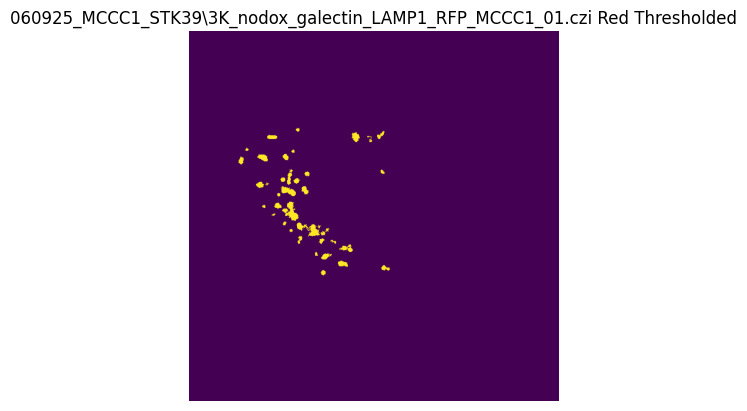

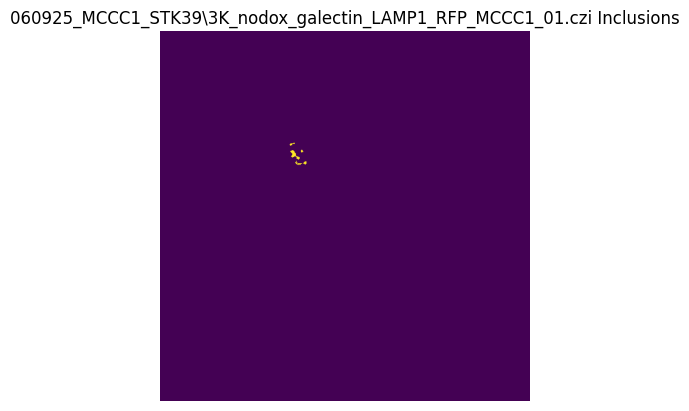

bleedthrough detected, using Otsu's threshold value for red


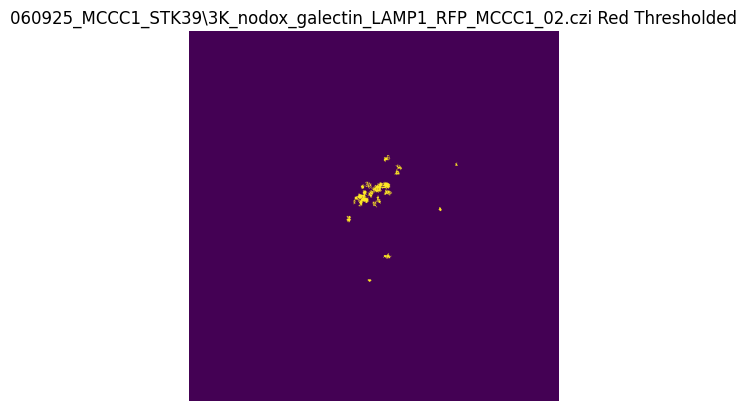

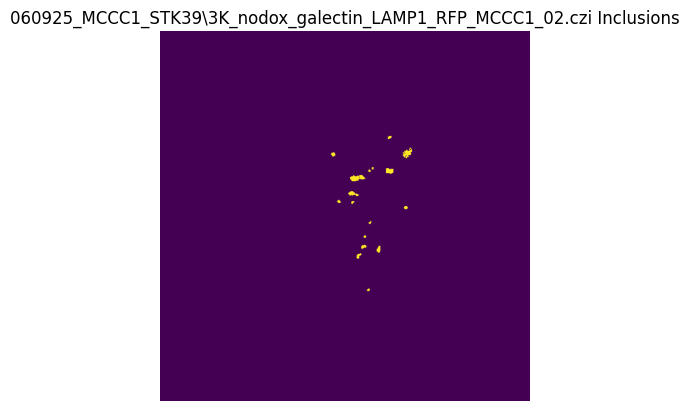

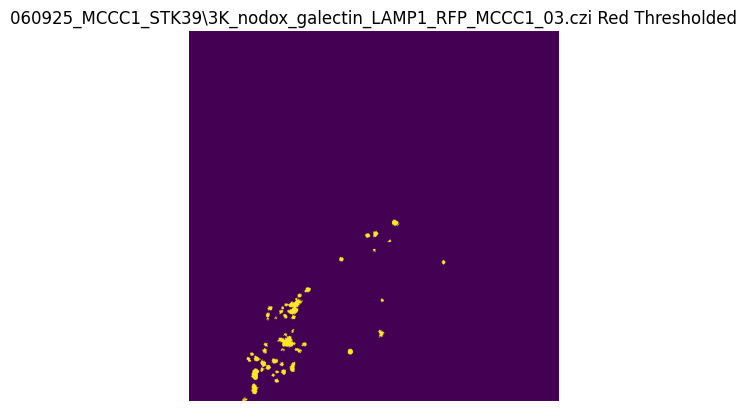

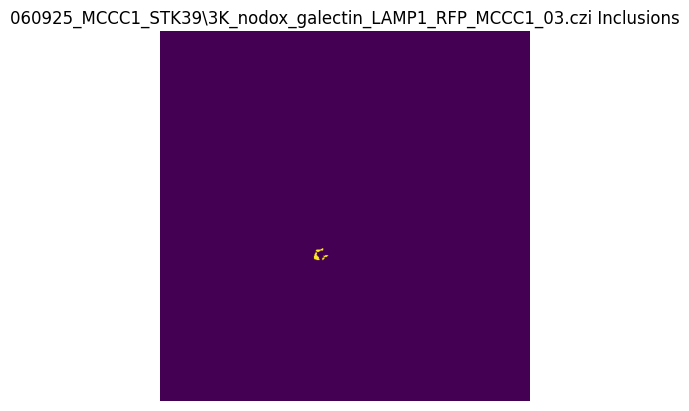

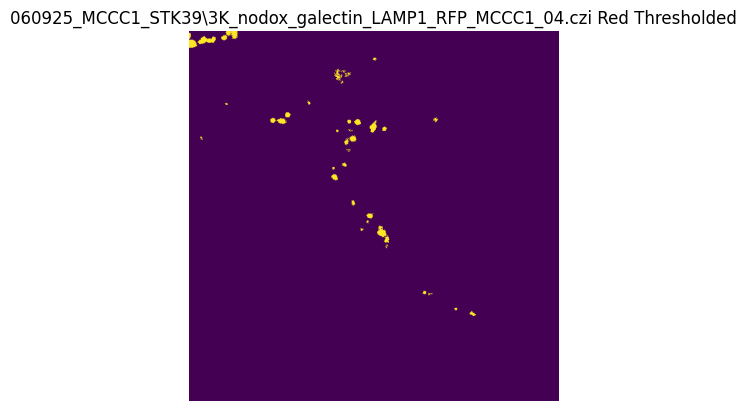

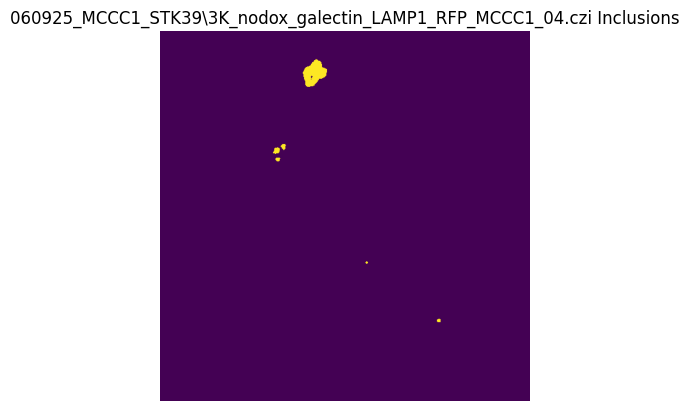

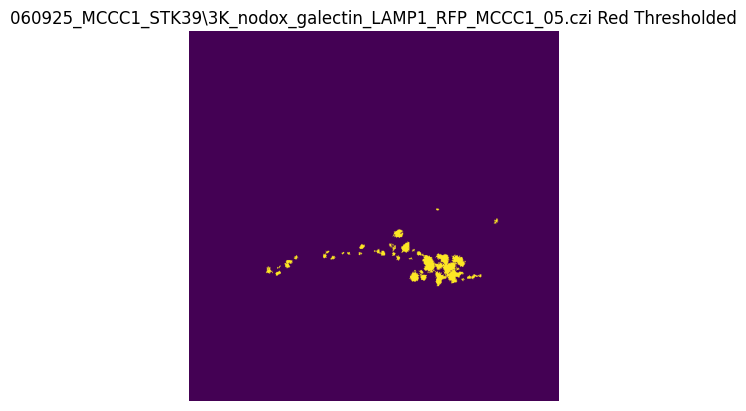

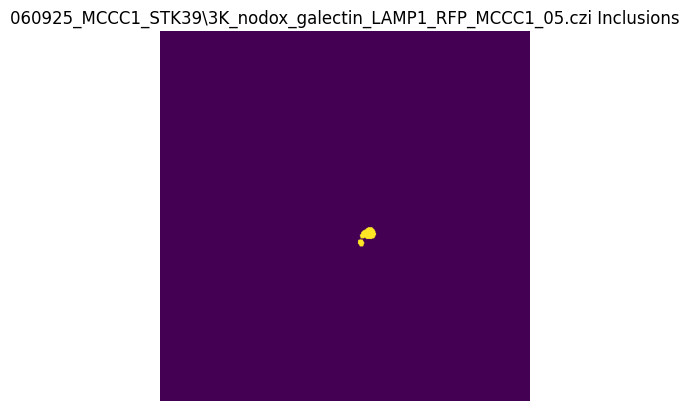

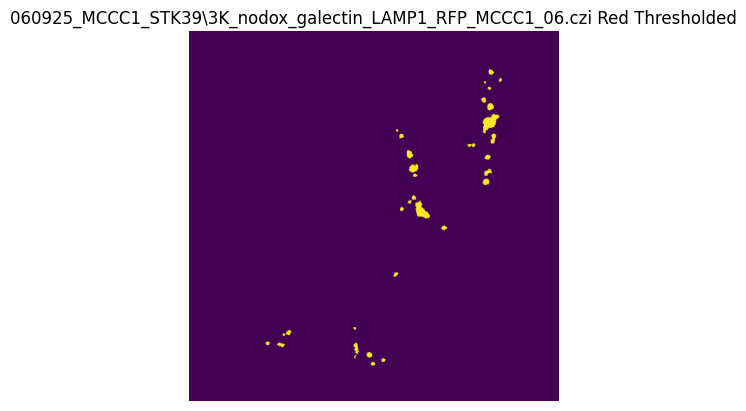

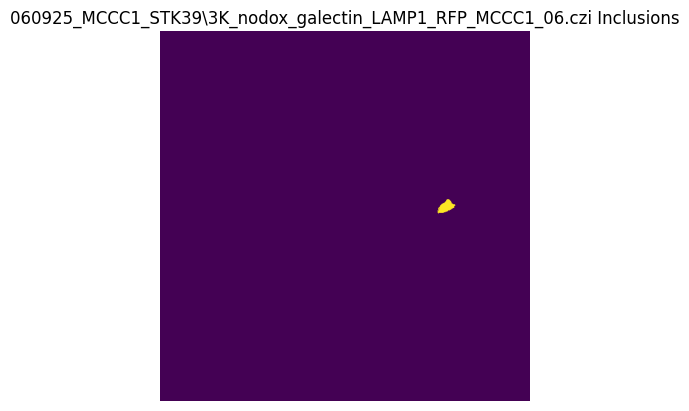

bleedthrough detected, using Otsu's threshold value for red


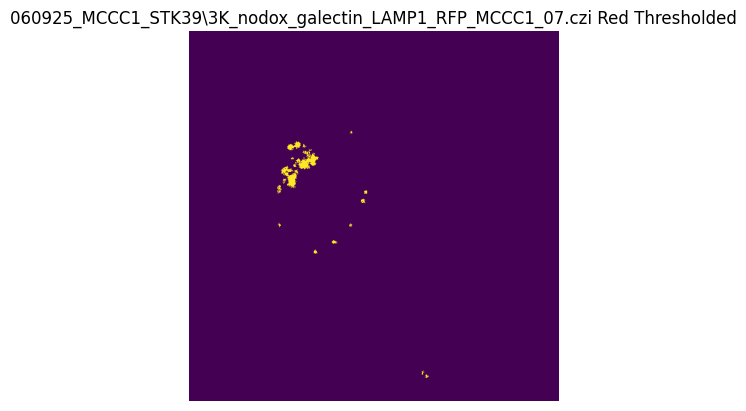

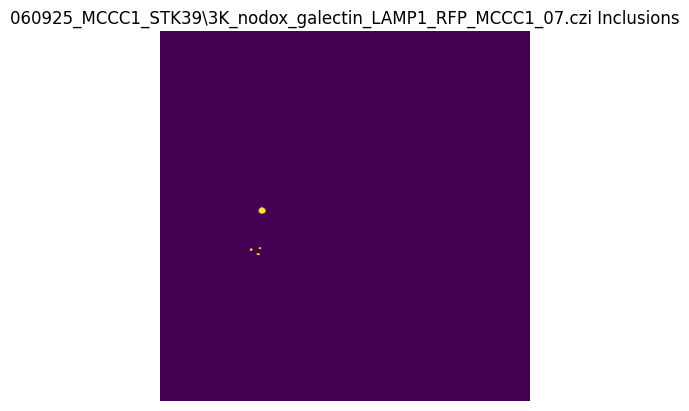

bleedthrough detected, using Otsu's threshold value for red


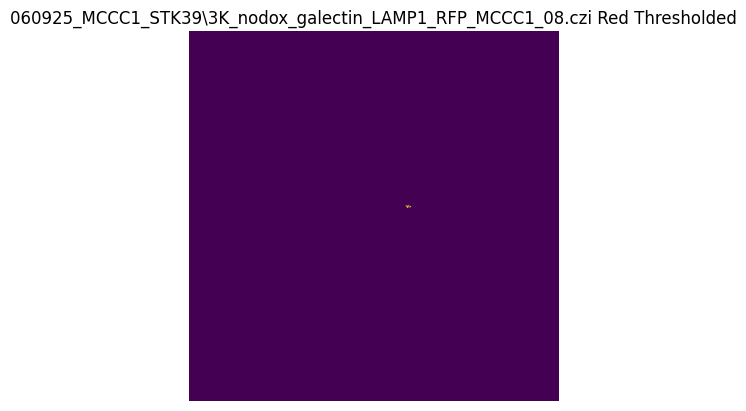

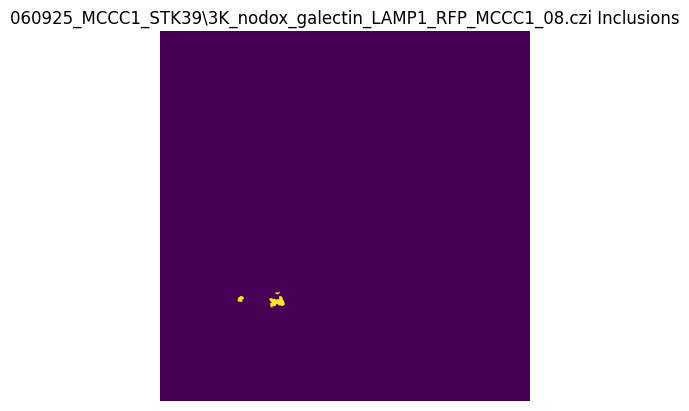

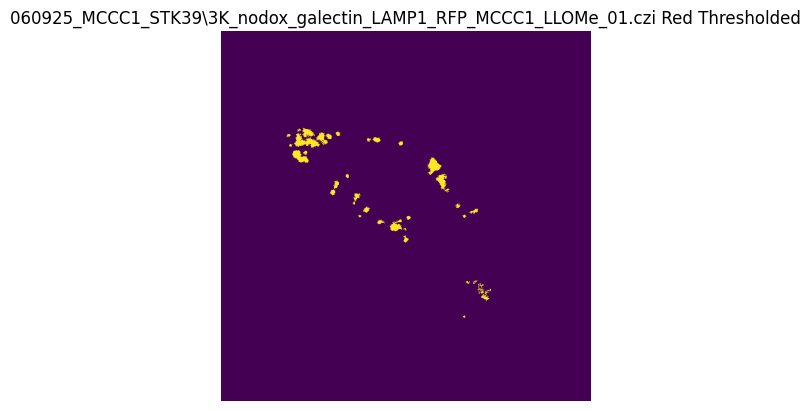

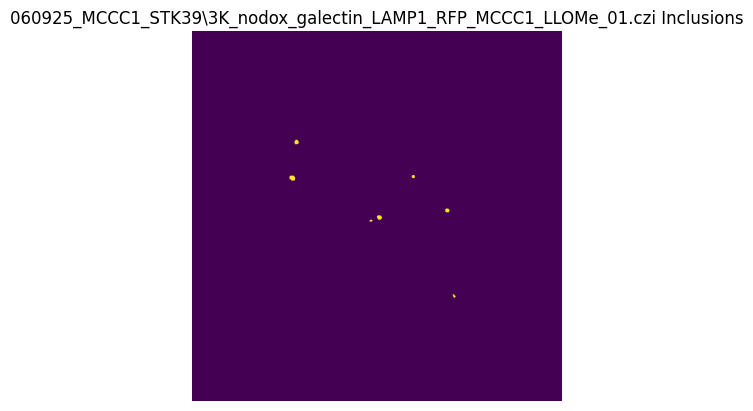

bleedthrough detected, using Otsu's threshold value for red


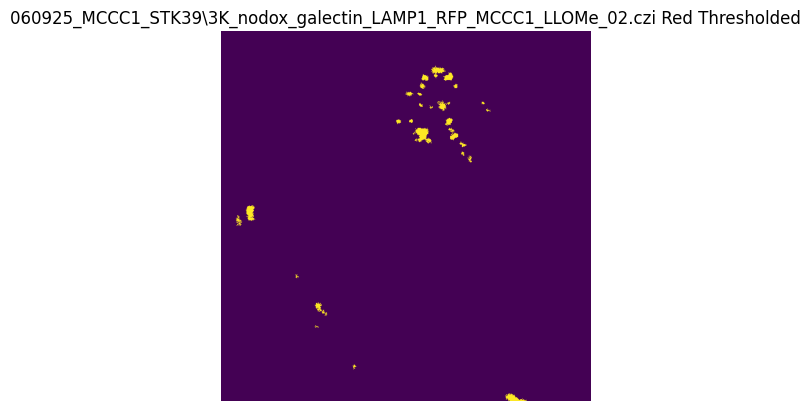

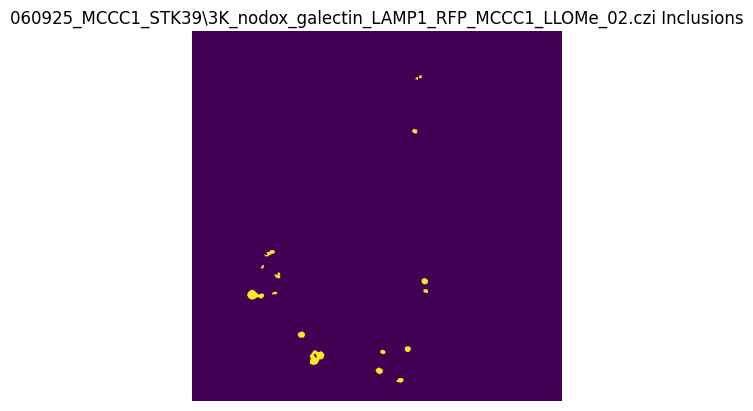

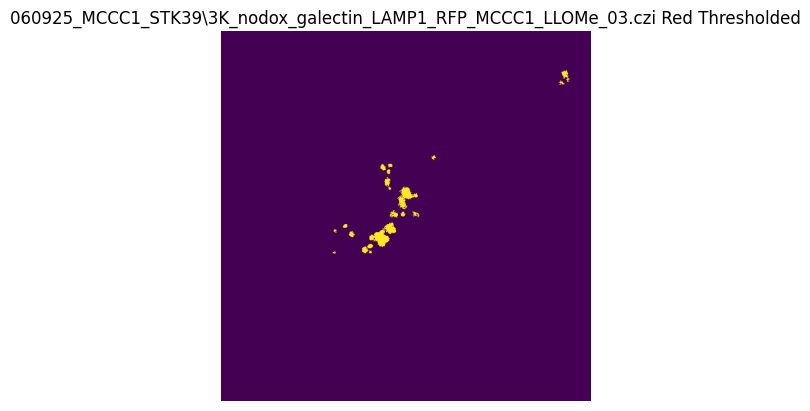

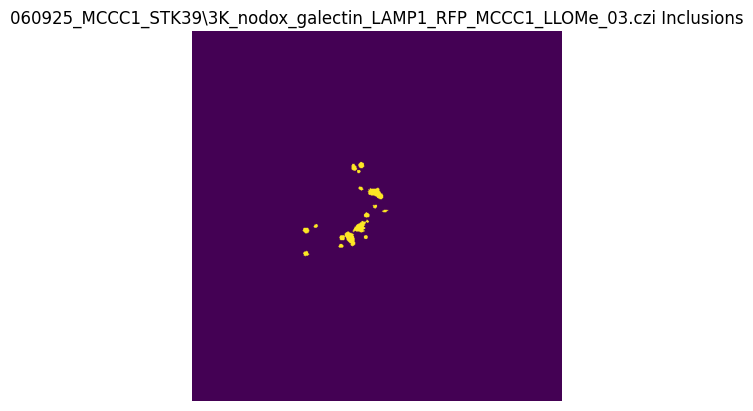

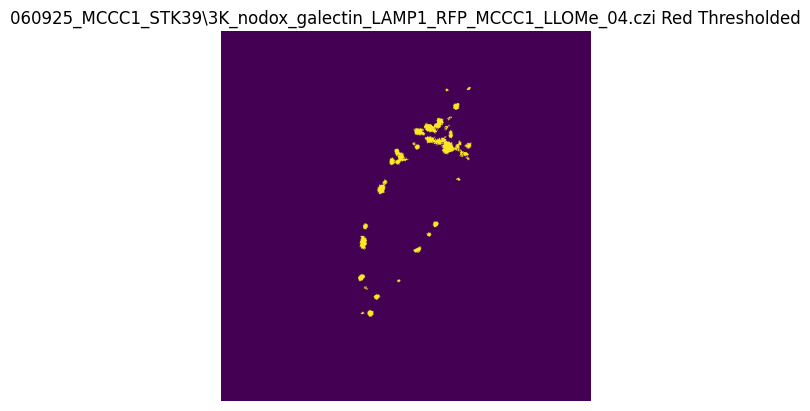

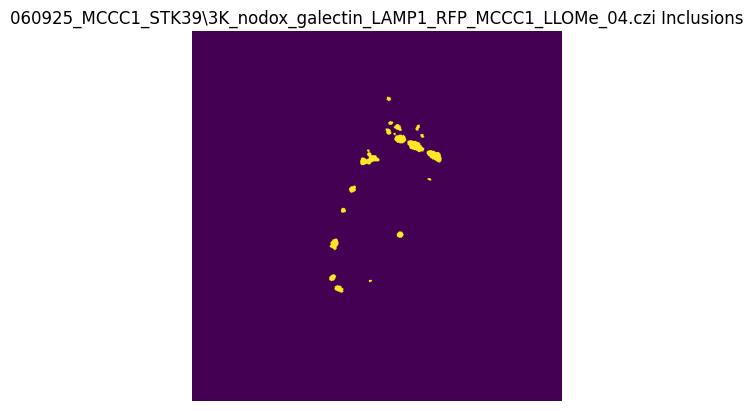

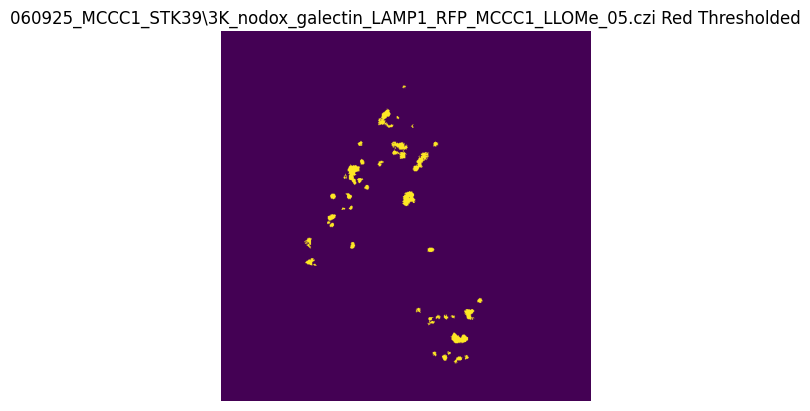

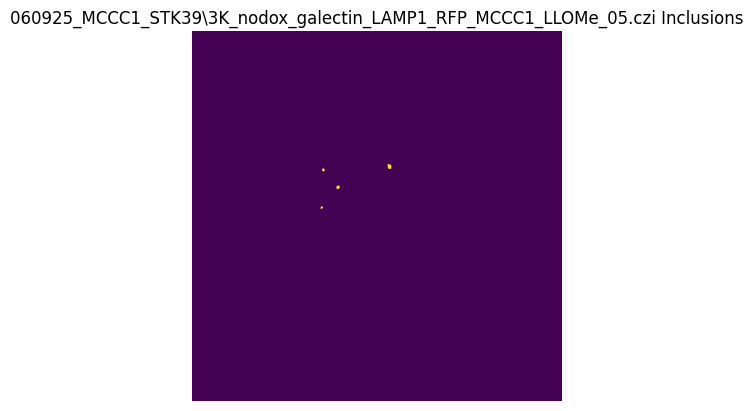

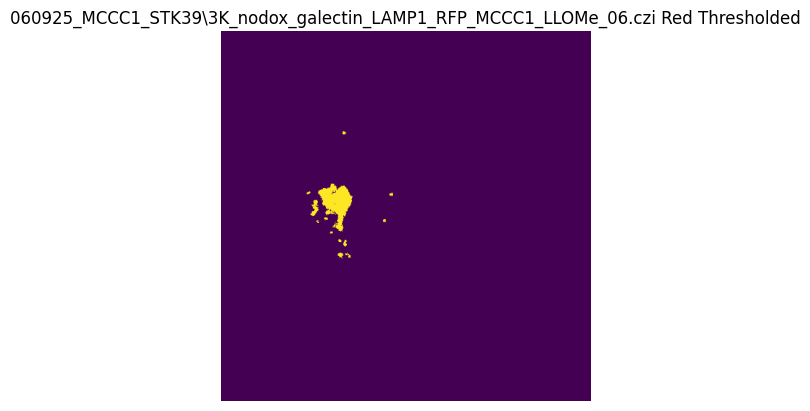

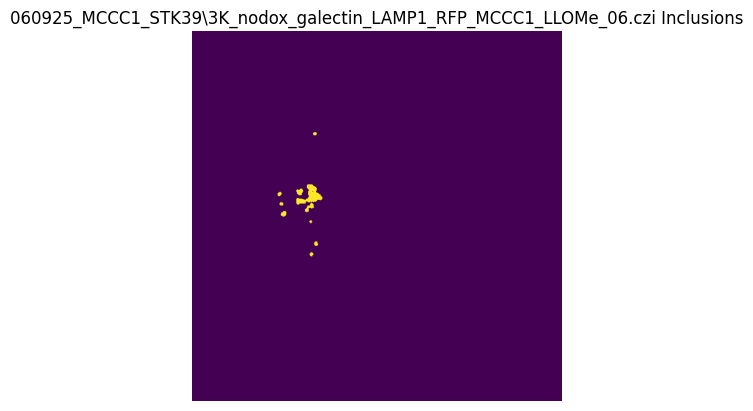

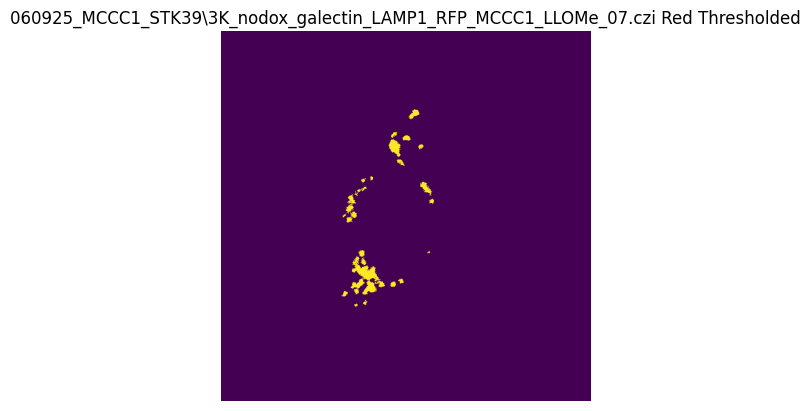

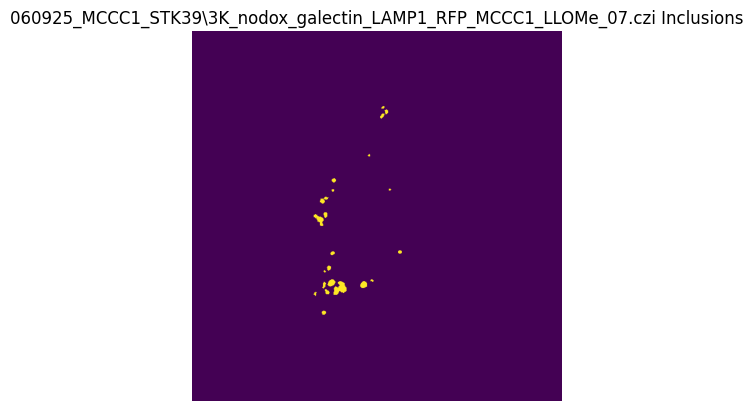

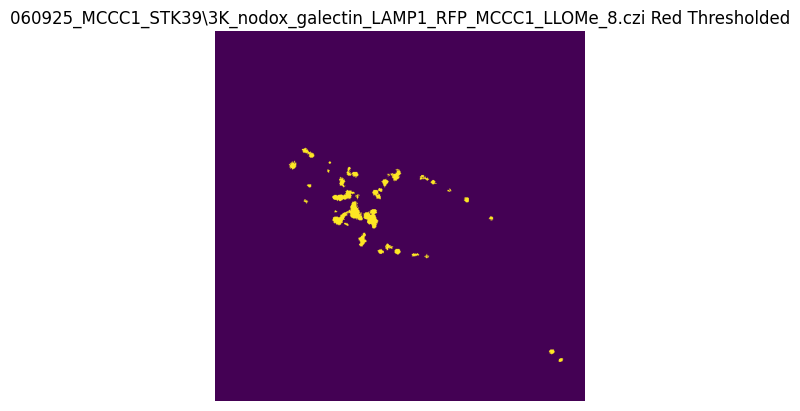

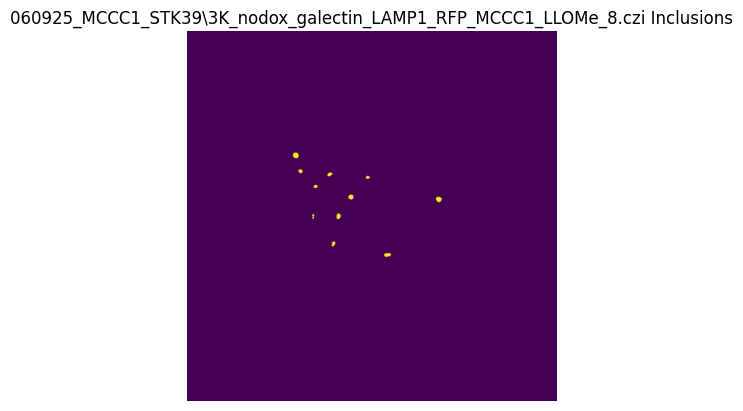

bleedthrough detected, using Otsu's threshold value for red


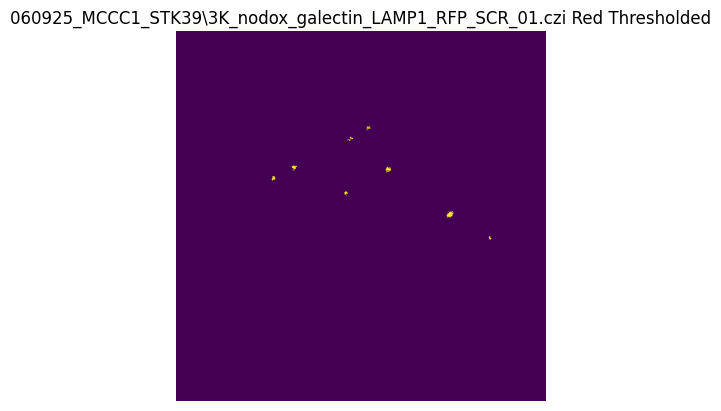

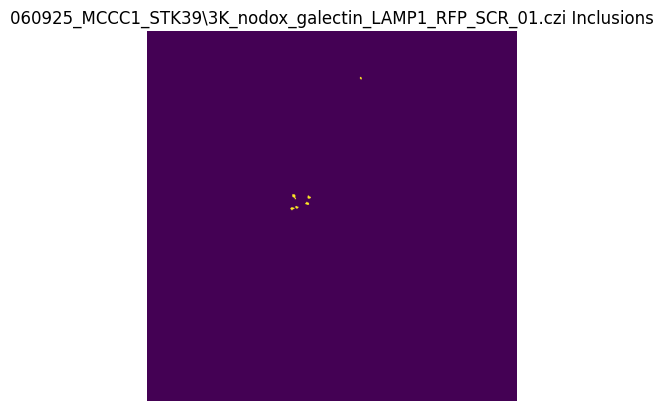

bleedthrough detected, using Otsu's threshold value for red


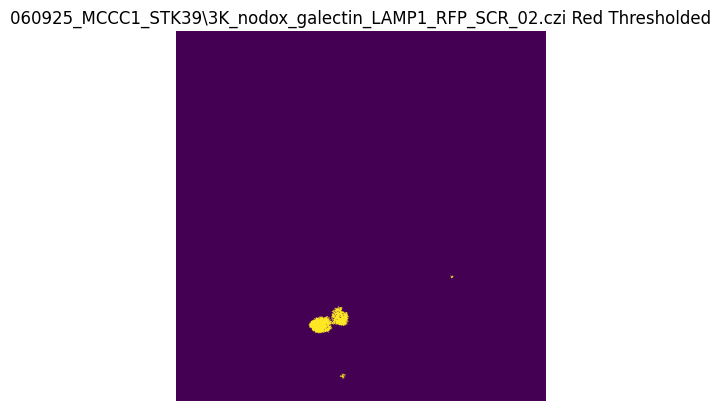

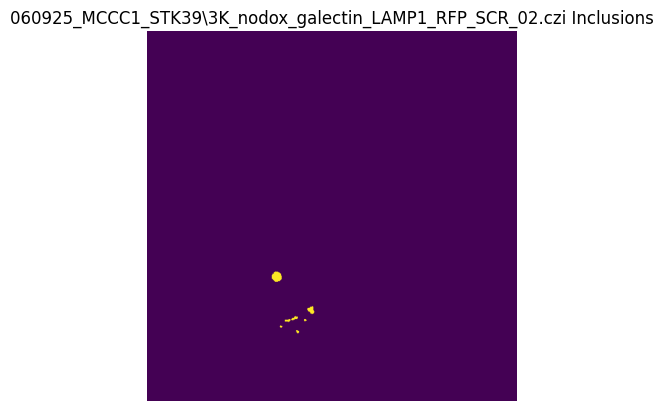

bleedthrough detected, using Otsu's threshold value for red


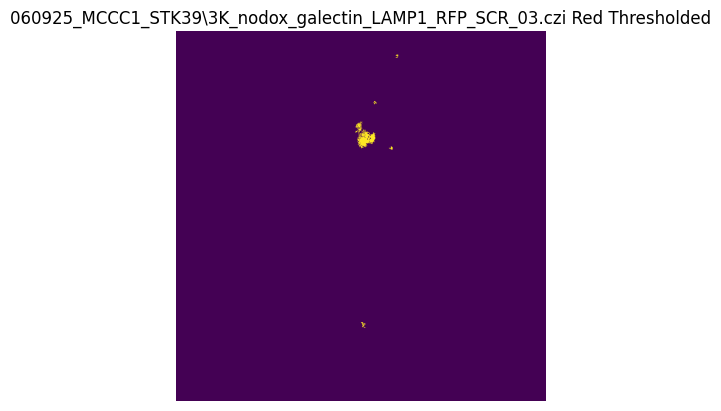

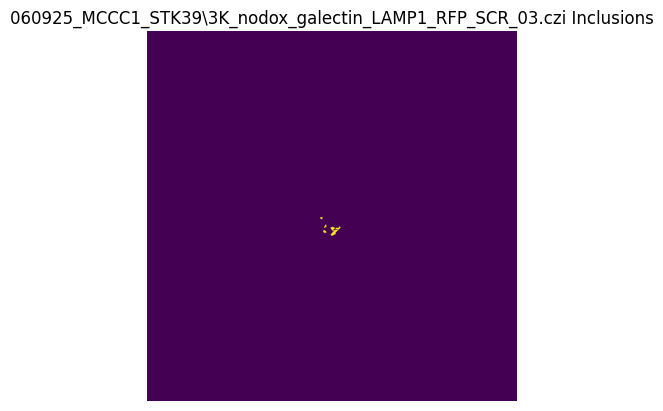

bleedthrough detected, using Otsu's threshold value for red


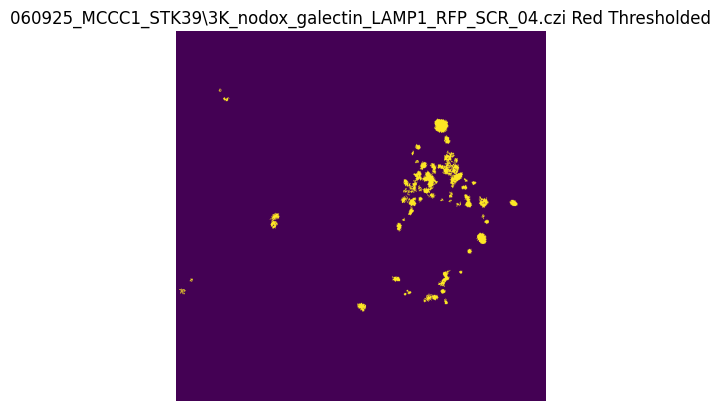

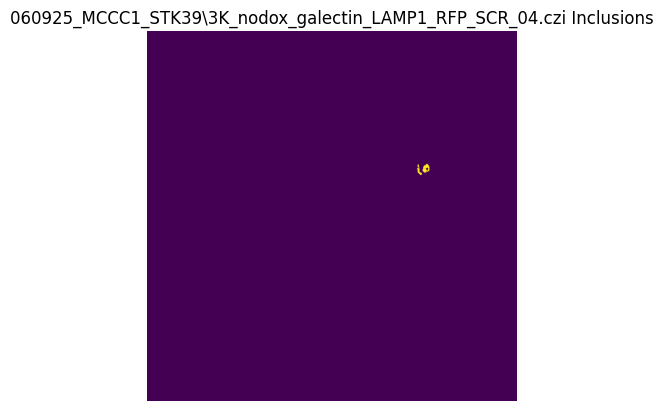

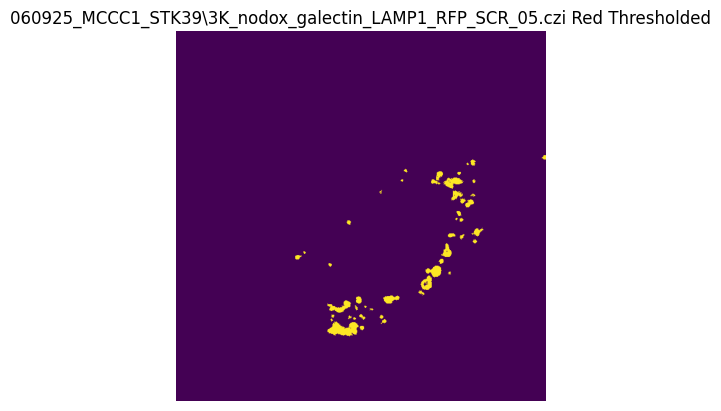

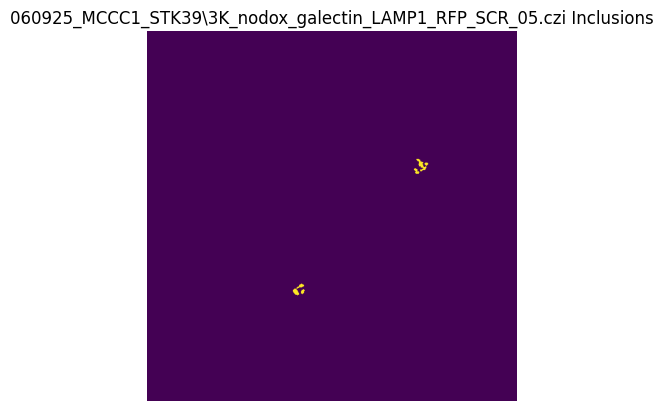

bleedthrough detected, using Otsu's threshold value for red


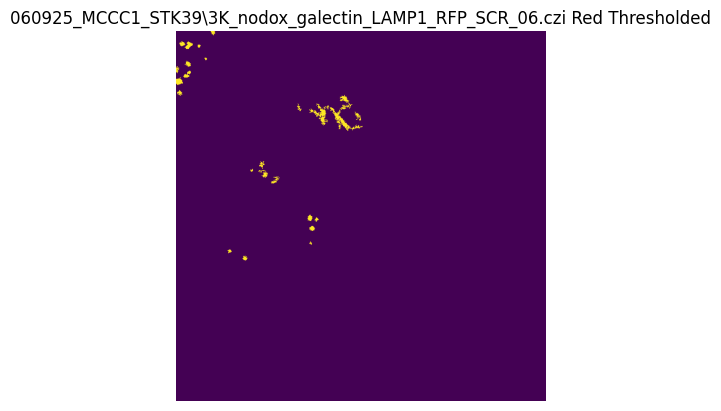

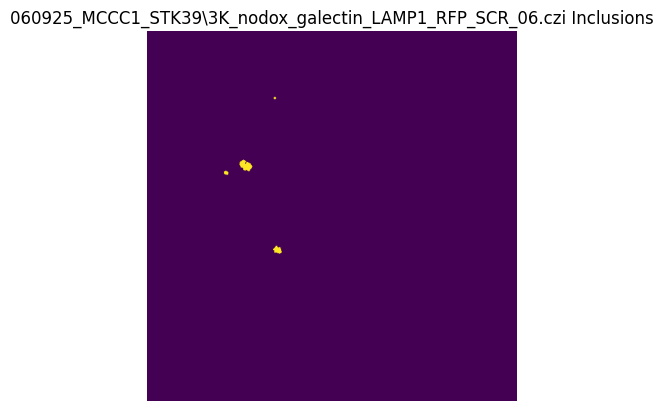

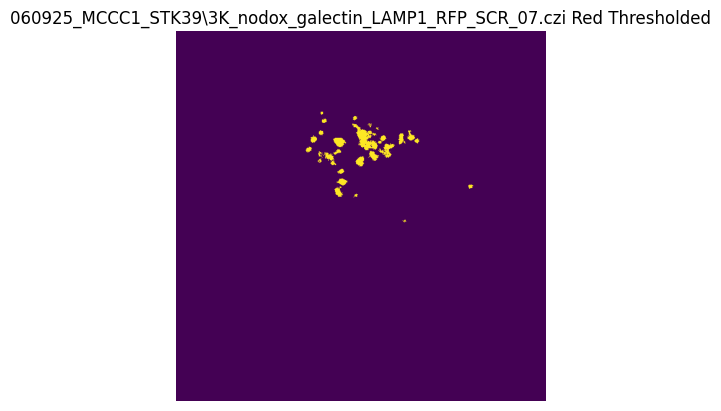

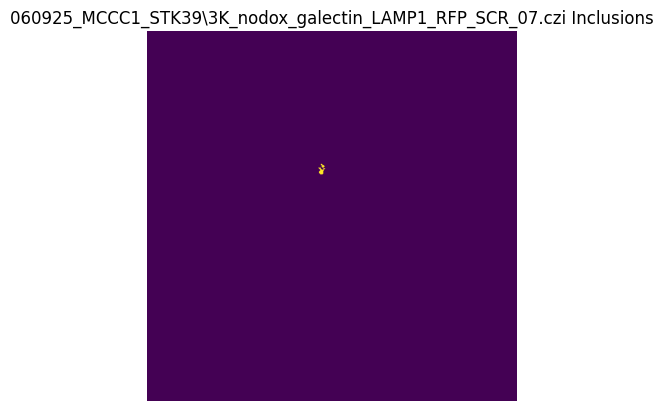

bleedthrough detected, using Otsu's threshold value for red


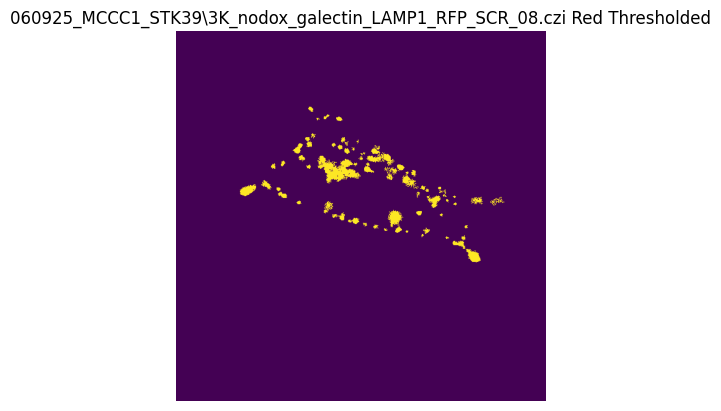

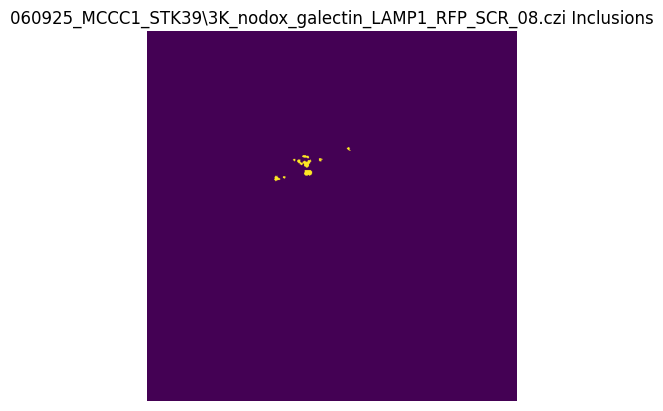

bleedthrough detected, using Otsu's threshold value for red


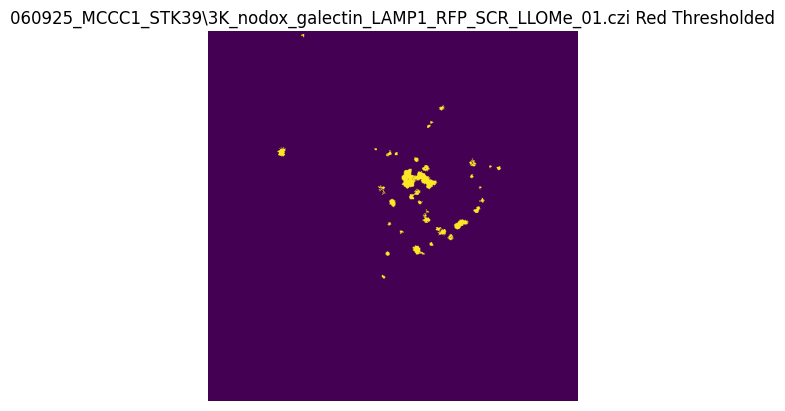

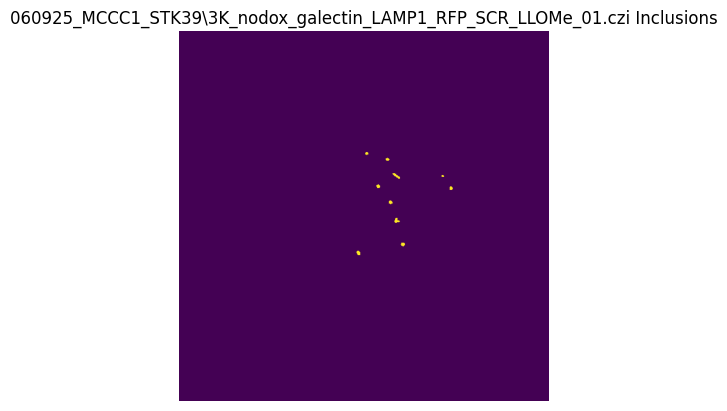

bleedthrough detected, using Otsu's threshold value for red


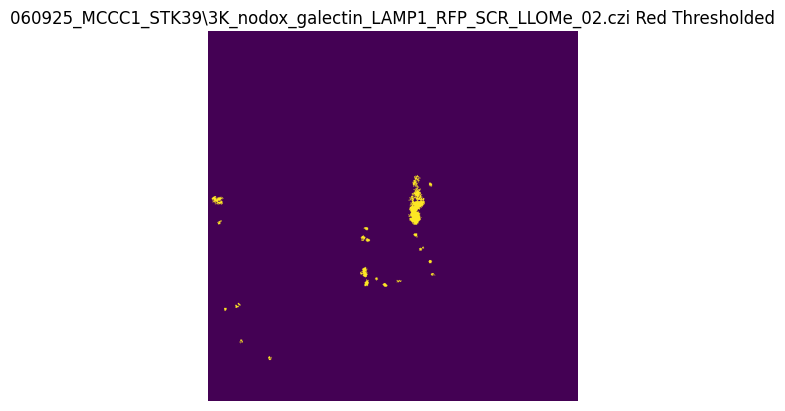

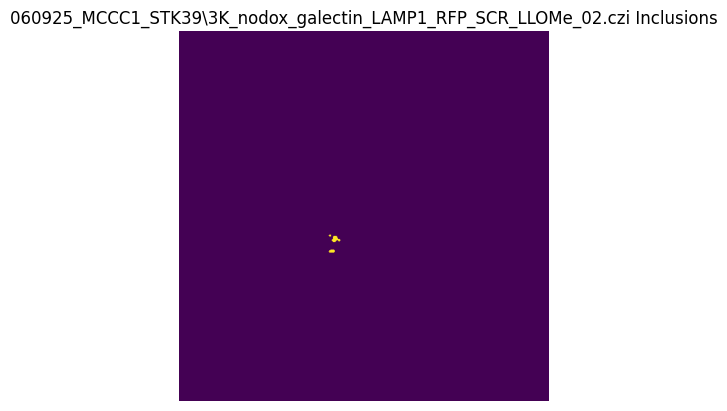

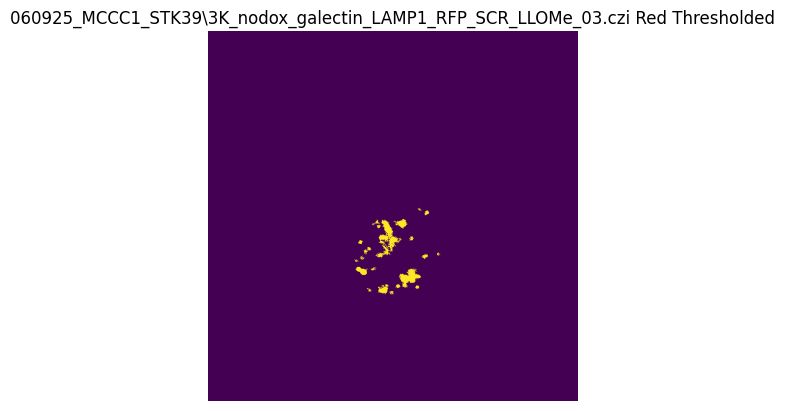

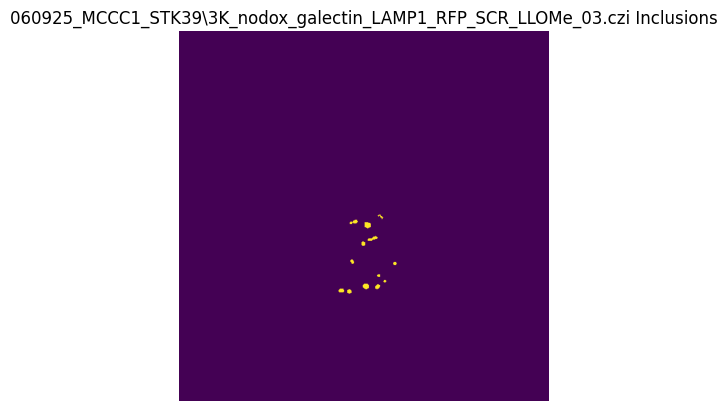

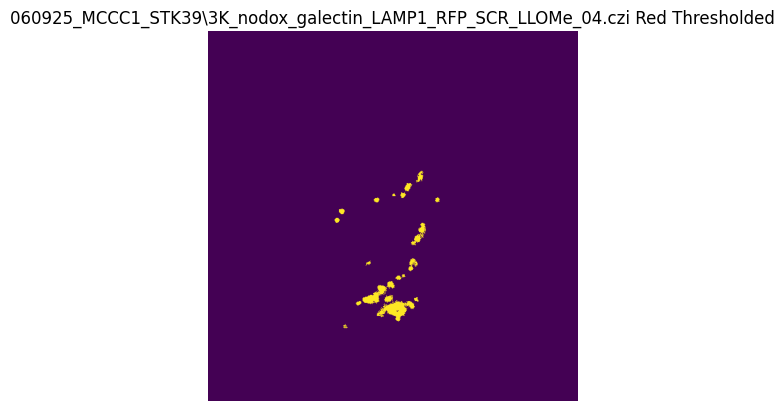

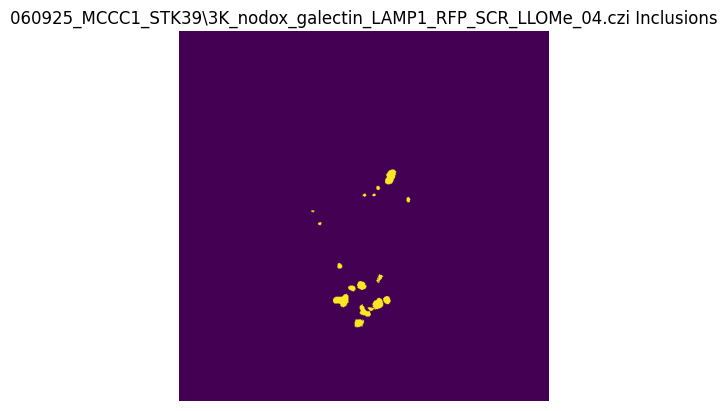

bleedthrough detected, using Otsu's threshold value for red


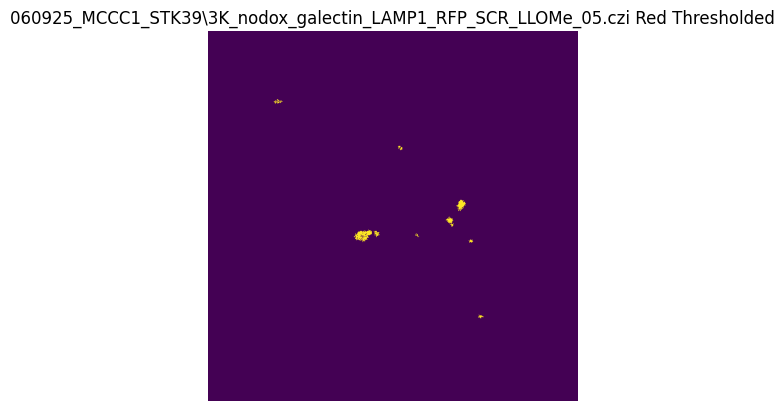

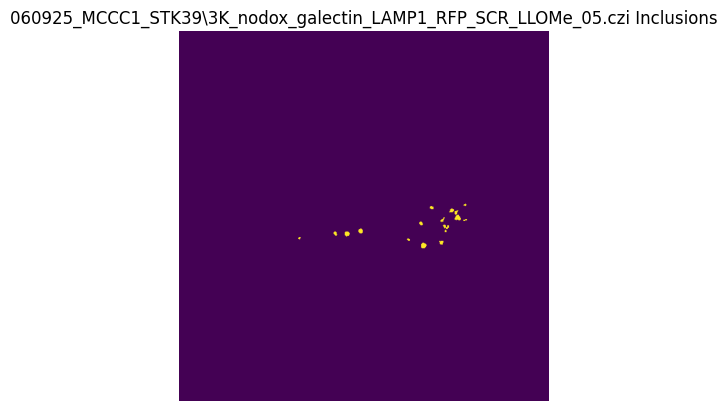

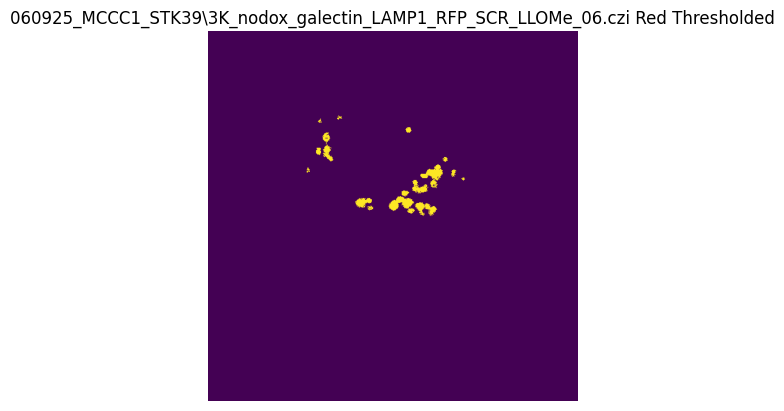

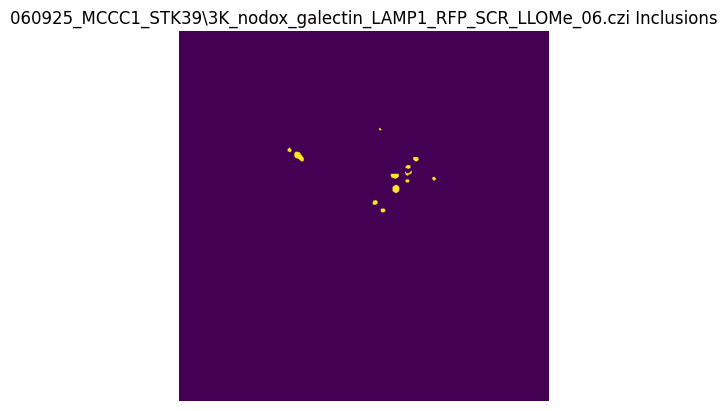

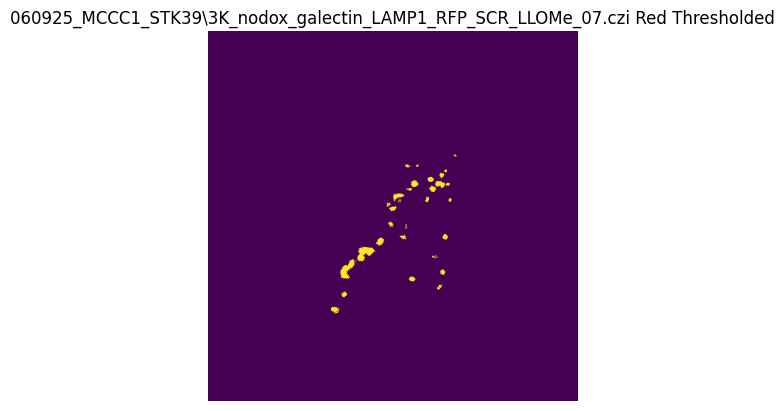

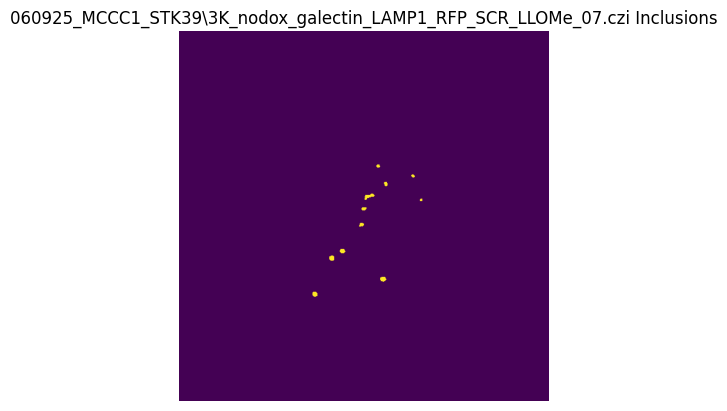

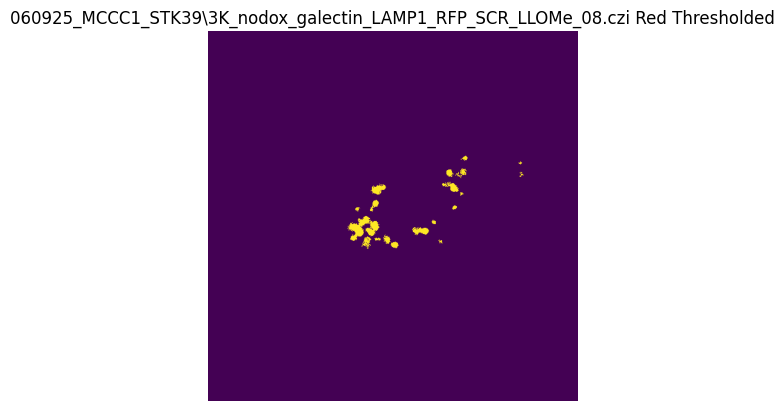

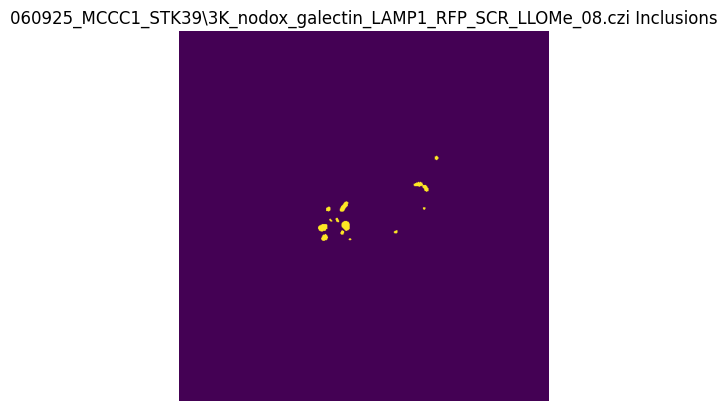

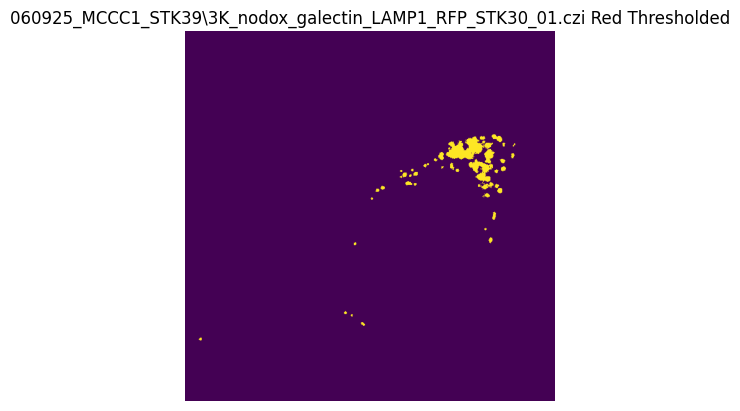

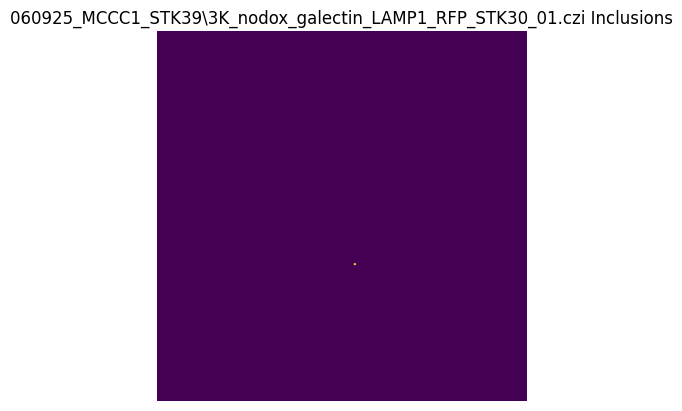

bleedthrough detected, using Otsu's threshold value for red


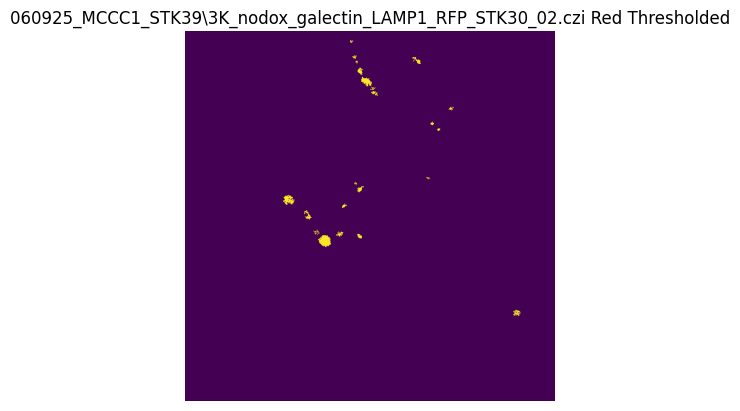

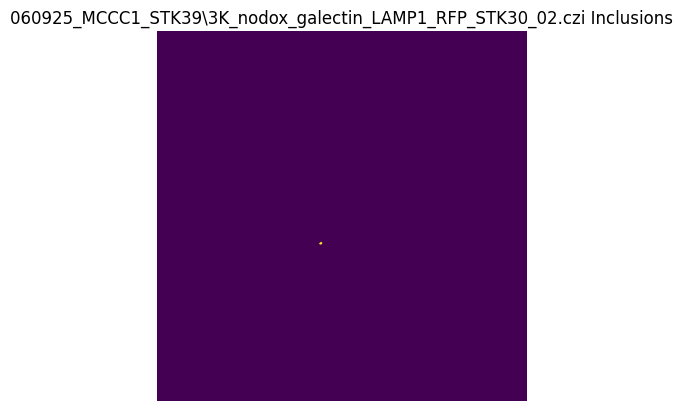

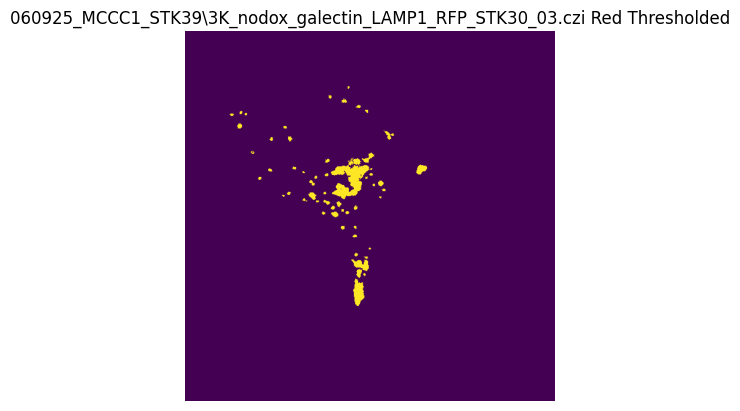

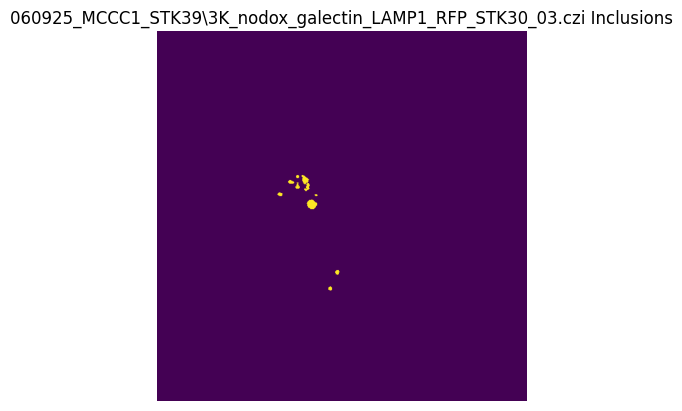

bleedthrough detected, using Otsu's threshold value for red


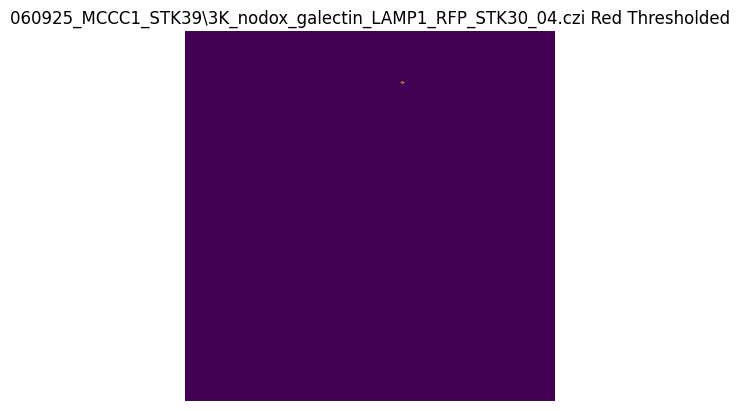

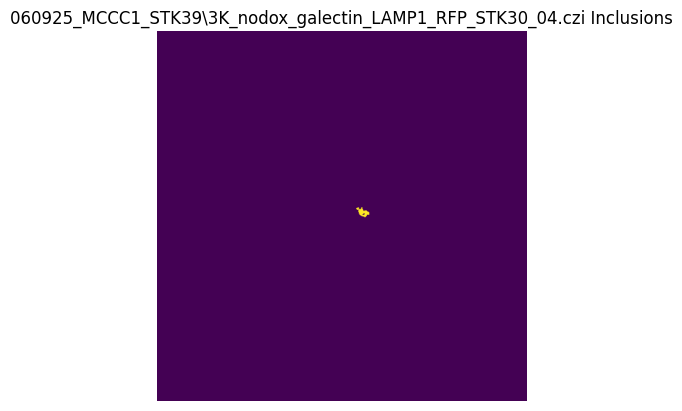

bleedthrough detected, using Otsu's threshold value for red


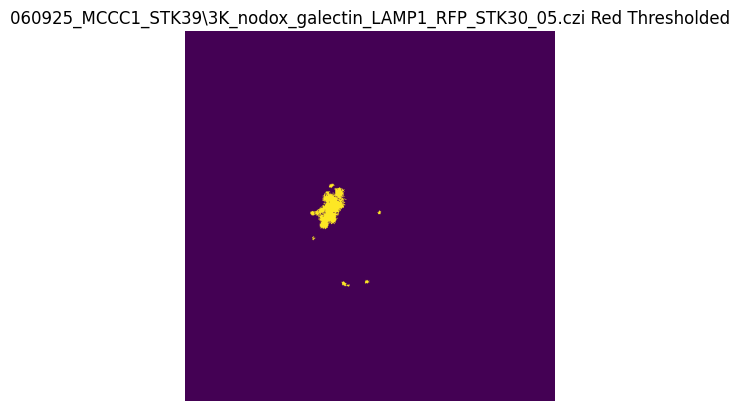

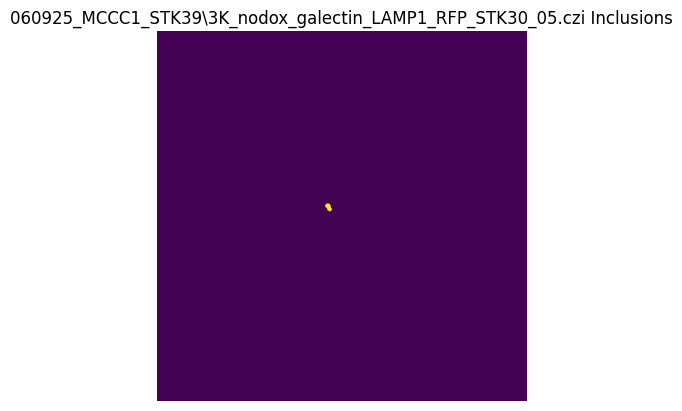

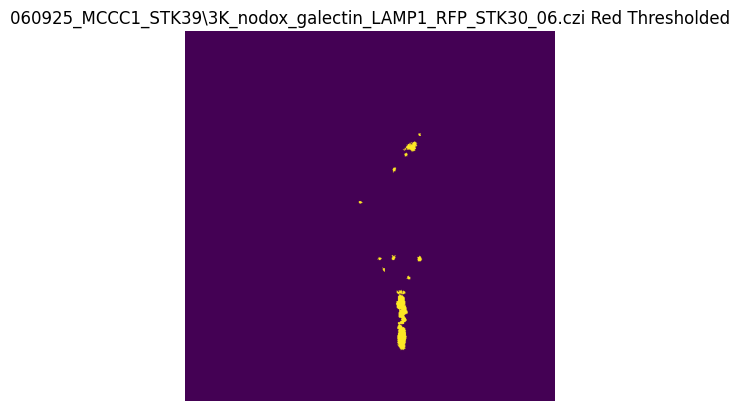

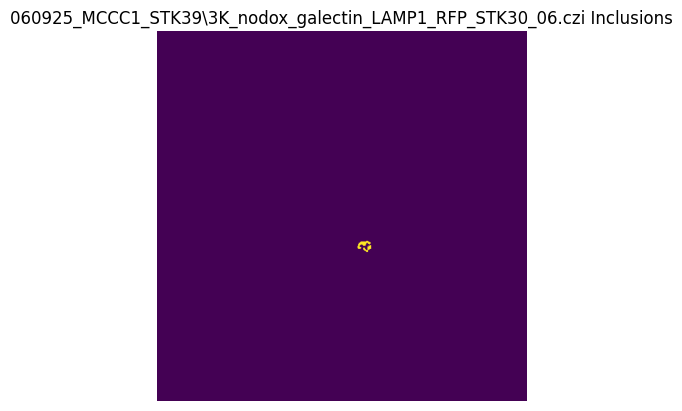

bleedthrough detected, using Otsu's threshold value for red


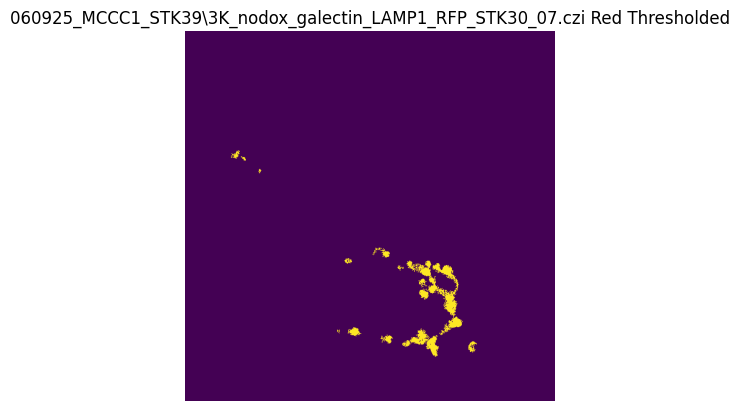

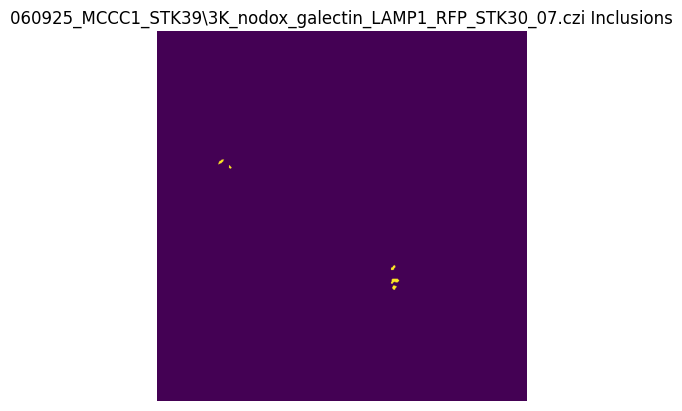

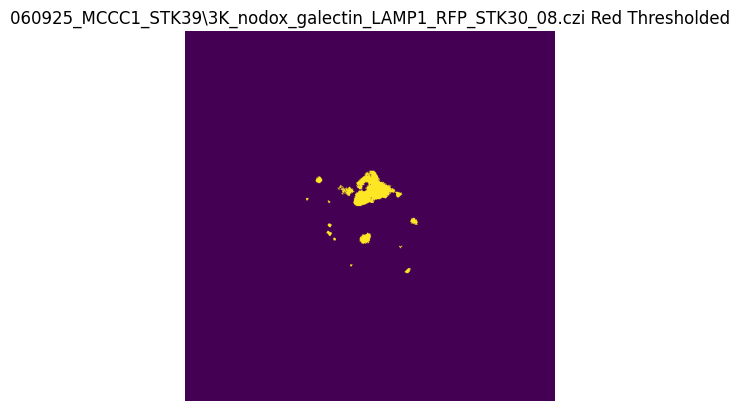

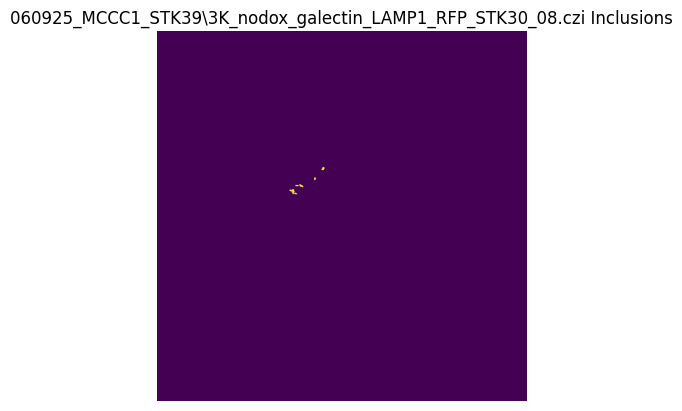

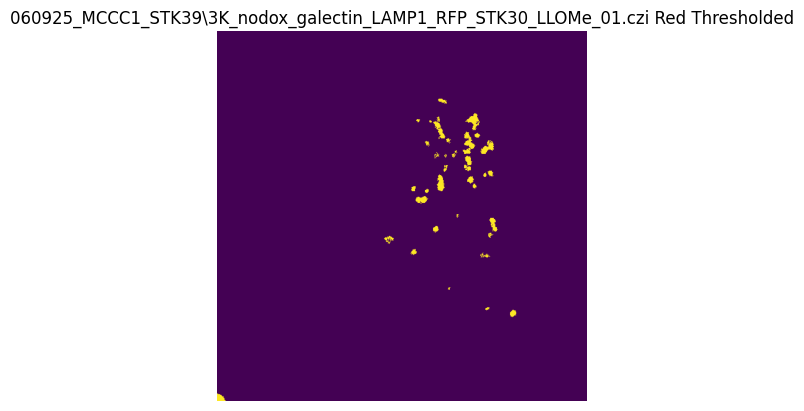

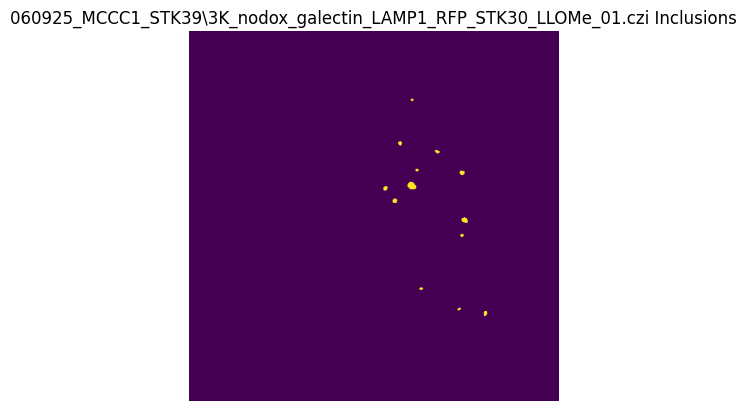

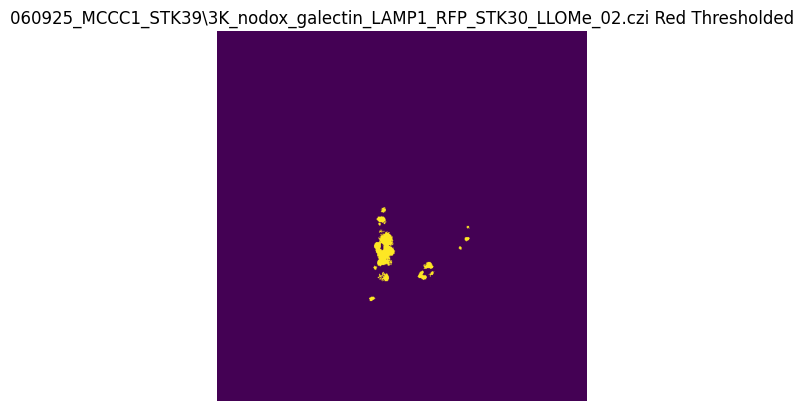

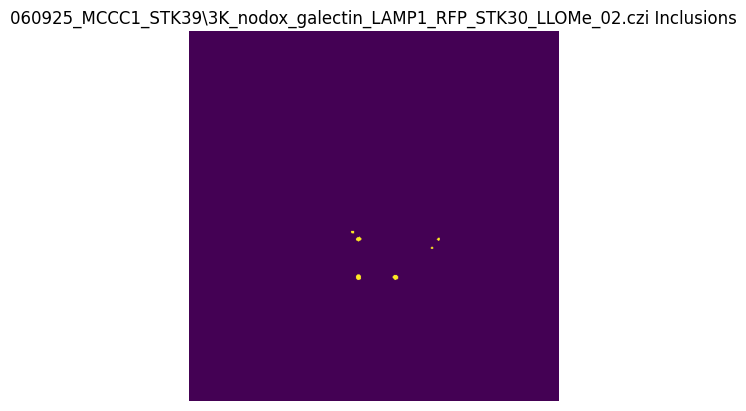

bleedthrough detected, using Otsu's threshold value for red


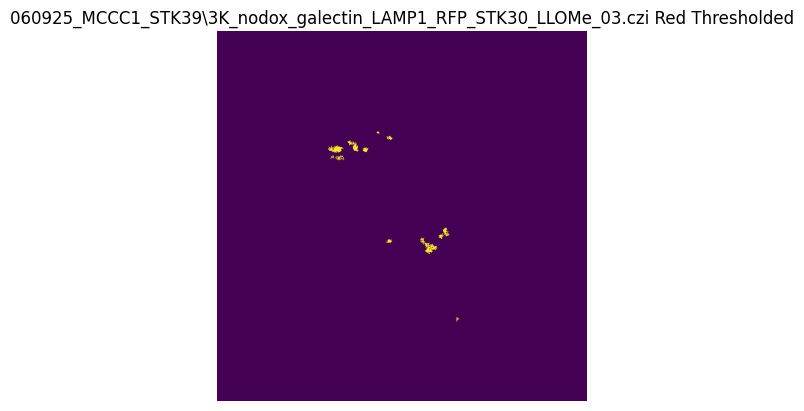

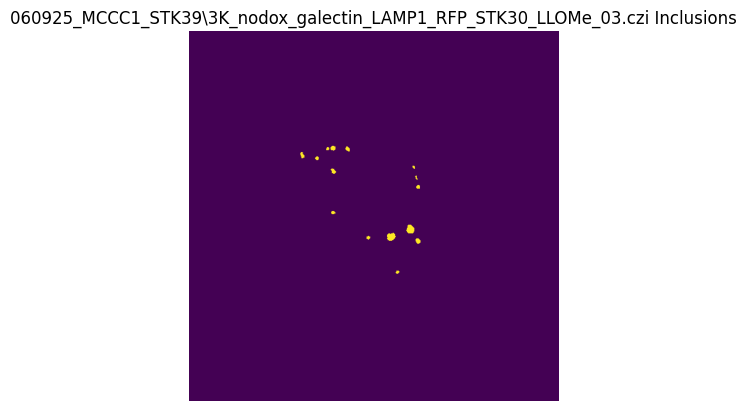

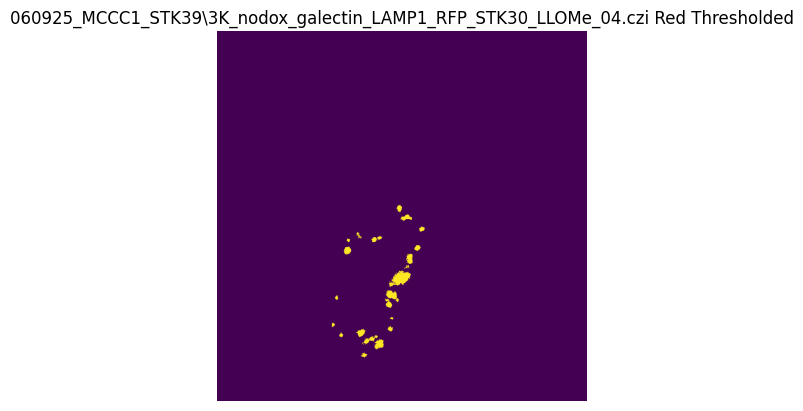

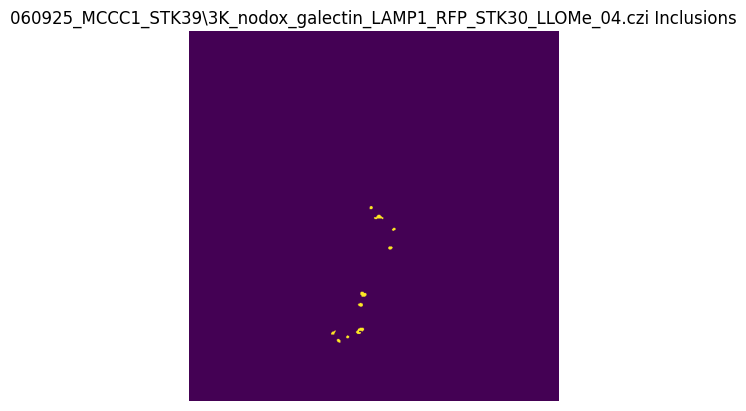

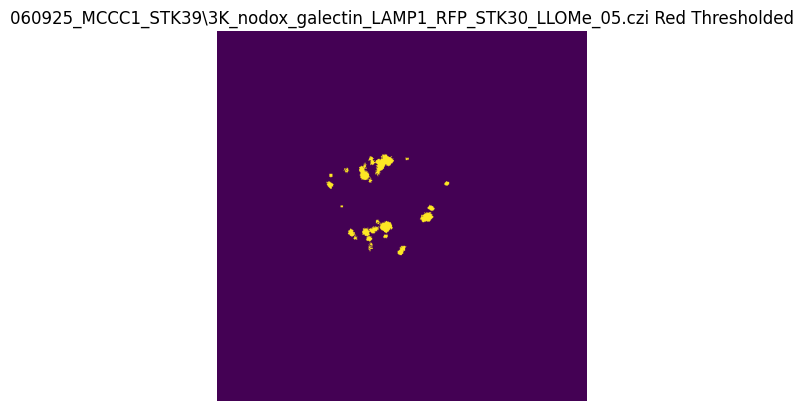

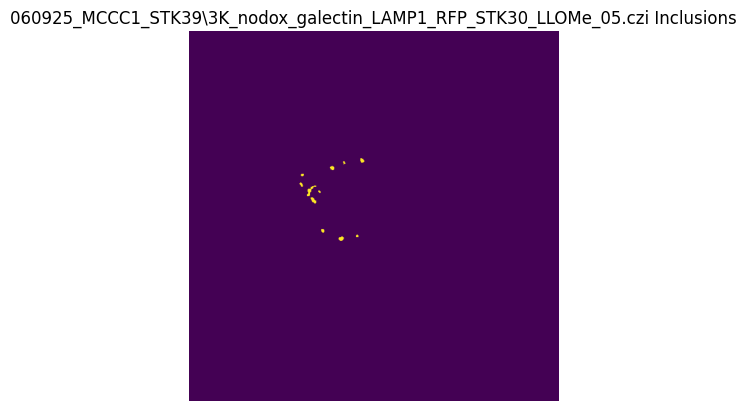

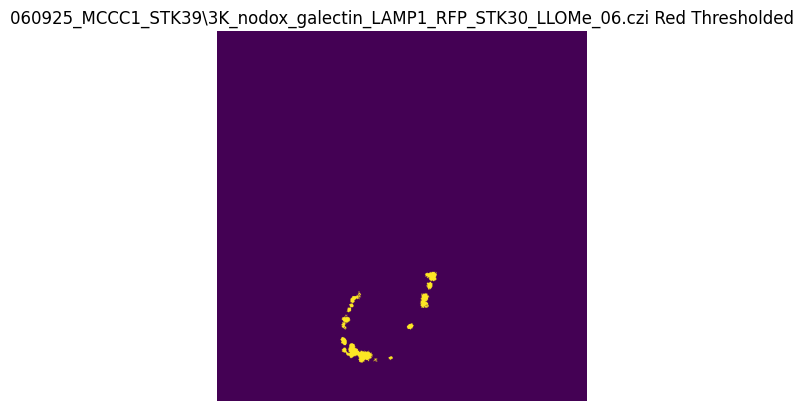

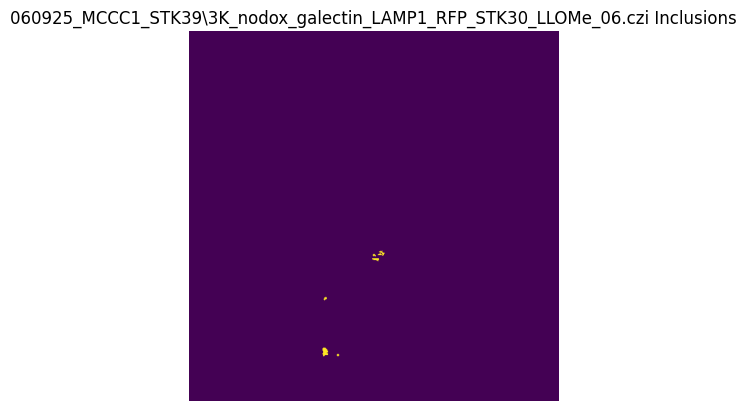

bleedthrough detected, using Otsu's threshold value for red


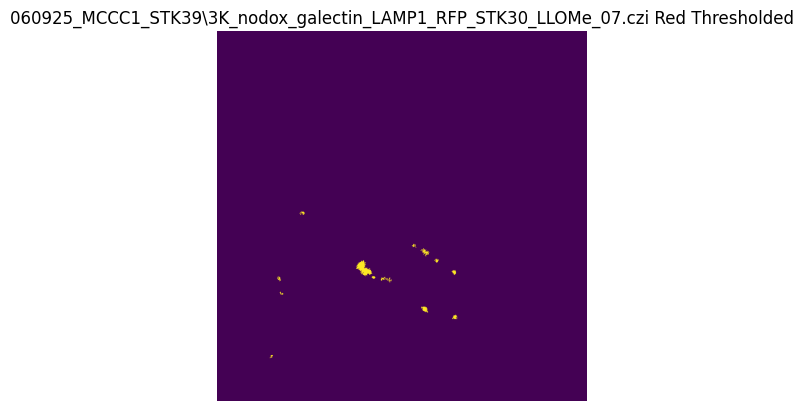

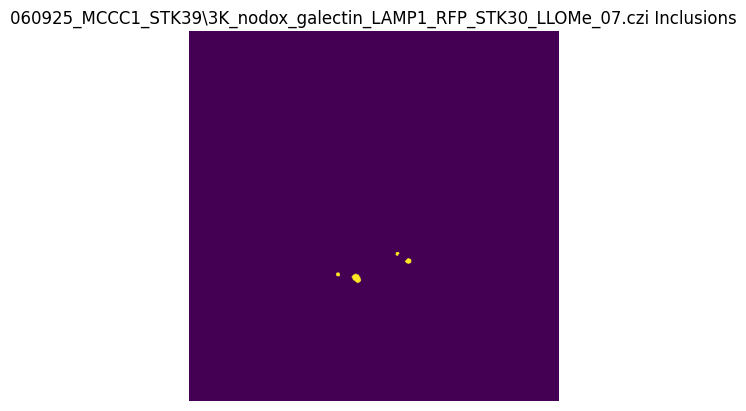

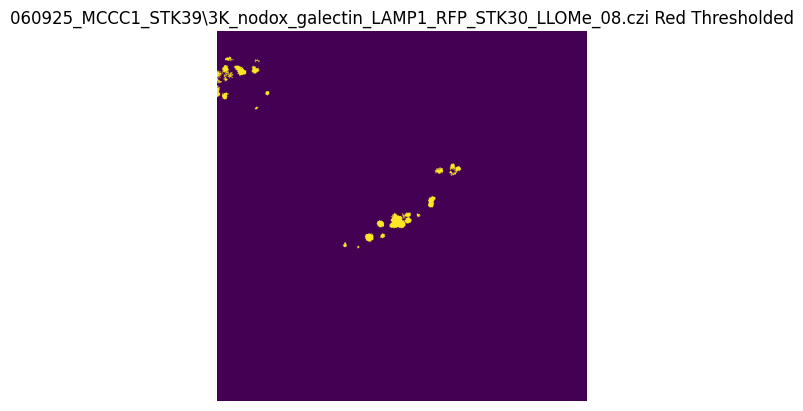

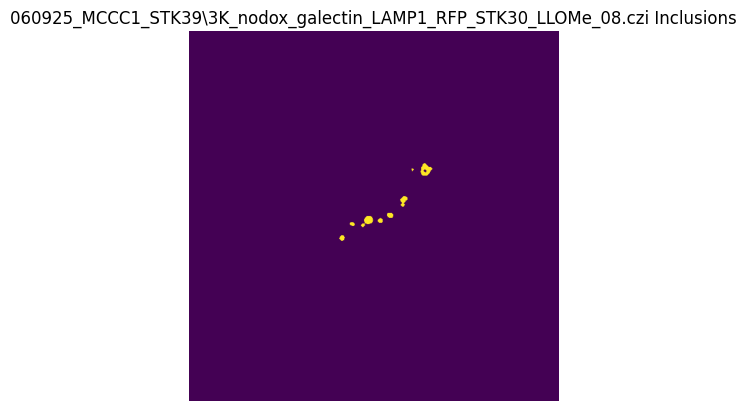

ValueError: No objects to concatenate

In [15]:
def main(image_folder):
    images_to_analyze = extract_image_paths(image_folder)
    output_dir = os.getcwd()

    df_dox_summary = []
    df_no_dox_summary = []
    df_inclusion_summary = []
    for path in images_to_analyze:
        image = read_image(path)
        image_squeezed = np.squeeze(image) 

        red, green = extract_channels(image_squeezed)
        if "nodox" in path:
            df_cell_summary_no_dox = no_dox_analysis(red, green, path)
            df_no_dox_summary.append(df_cell_summary_no_dox)
            #continue

        else: 
            #df_cell_summary, df_cell_inclusions_summary = dox_analysis(red, green, path)
            #df_dox_summary.append(df_cell_summary)
            #df_inclusion_summary.append(df_cell_inclusions_summary)
            continue

    df_summary_combined_df = pd.concat(df_no_dox_summary, ignore_index=True)
    output_df_summary_path = os.path.join(output_dir, '060925_MCCC1_STK39_nodox.xlsx')
    df_summary_combined_df.to_excel(output_df_summary_path, index=False)

    df_inclusion_summary_combined_df = pd.concat(df_dox_summary, ignore_index=True)
    output_df_inclusion_summary_path = os.path.join(output_dir, '6625_WT_dox.xlsx')
    df_inclusion_summary_combined_df.to_excel(output_df_inclusion_summary_path, index=False)

    df_inclusion_summary_combined_df = pd.concat(df_inclusion_summary, ignore_index=True)
    output_df_inclusion_summary_path = os.path.join(output_dir, '6625_WT_dox_inclusions.xlsx')
    df_inclusion_summary_combined_df.to_excel(output_df_inclusion_summary_path, index=False)



if __name__ == "__main__":
    image_folder = '060925_MCCC1_STK39'
    main(image_folder)
